In [13]:
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import os
import warnings
import numpy as np
import pymap3d as pm
from random import randrange
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names

matplotlib.style.use('ggplot')
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,8)

# Globals

In [14]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [15]:
def traj_RMSE(gt, est):
    e = gt-est
    se = e**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse

In [16]:
# rotation order
rot_order = 'xyz'

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Preprocess

In [17]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position, velocity and acceleration data into single arrays
    p_gps = np.hstack((x_gps, y_gps, z_gps))
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.16
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next
        
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

    return tt_imu, lin_acc, ang_vel, theta_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias

# load radar data
def LoadRadar():
    # load ROS data from txt file - azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
    os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

    lines = []
    with open('2022-02-17.txt') as f:
        lines = f.readlines()

    # these lists will keep all the returns from the entire video
    theta_list = []
    v_r_list = []
    r_list = []

    # these lists will keep the returns just for one frame of the video
    sec_list = []
    nsec_list = []
    theta = [] # azimuth angle in !radians!
    v_r = [] # radial speed
    r = [] # range

    # iterate over the entire video
    for line in lines:
        # check if we have a new scan
        if line[0:3] == "New":
            # if it is not the first, add the previous scan to the list of all the scans
            if theta and v_r:
                r_list.append(r)
                theta_list.append(theta)
                v_r_list.append(v_r)

            # reset the lists for this current frame
            r = []
            theta = []
            v_r = []

        elif line[0:3] == "Sec":
            sec_list.append(int(line[5:-1]))
        elif line[0:4] == "Nsec":
            nsec_list.append(int(line[6:-1]))
        elif line[0:1] == "r":
            r.append(float(line[2:-1]))
        elif line[0:1] == "a":
            theta.append(np.deg2rad(float(line[2:-1])))
        elif line[0:3] == "v_r":
            v_r.append(float(line[4:-1]))

    # append the last 2 items
    r_list.append(r)
    theta_list.append(theta)
    v_r_list.append(v_r)

    temp = [i*1e-9 for i in nsec_list]
    t_radar = [sum(x) for x in zip(sec_list, temp)]
    tt_radar = [x-t_radar[0] for x in t_radar]

    return tt_radar, r_list, theta_list, v_r_list

# Radar Odom

## Functions

In [18]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# part 1 - Ransac function
def Ransac(theta, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    # c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5 # 5 is chosen arbitrarily
    if c2_:
        return False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if i>0:
            if cond or i>=max_iter:
                break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
            num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
                # fill the A and b matrix
                A1 = np.cos(theta[j])
                A2 = np.sin(theta[j])
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ    
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and yaw rate
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
                e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                # calculate the % of inliers and
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria == "num_inliers":
                    # keep the inliers and outliers
                    best_inliers = current_inliers
                    best_outliers = current_outliers
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                # calculate the % of error
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria=="error":
                    best_inliers = current_inliers
                    best_outliers = current_outliers

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return True, best_inliers, best_outliers, i, pct_e, pct_inl, SSR

# part 2 - LSQ
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
        A1 = np.cos(theta[j])
        A2 = np.sin(theta[j])
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem 
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
        e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR

# part 3 - ego-motion estimation
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

## Loop

In [19]:
# apply radar odometry on the the current radar scan
'''
Returns:

0. retflag : 0 = Not enough non-zero radial_speed returns, 1 = Ransac didn't return enough inliers, 2 = 
1. v : vehicle radial velocity
2. w : vehicle yaw rate
'''
def radar_odometry(t, r_list, theta_list, v_r_list, v_prev):
    # tuning
    # Ransac
    # use sub-samples flag
    ransac_flag = True
    # stoppage criteria
    crit = "num_inliers"
    max_iter = 50 # maximum iterations
    stop_error = 0.05 # total error %
    stop_inl = 0.9 # % of inliers
    # percentage of error allowed to be considered inlier
    error_threshold = 0.1

    # Filtering
    radial_speed_filtering = False
    radial_threshold = 0 # removing all 0 radial speed returns
    range_filtering = False
    range_threshold = 1 # meters
    velocity_filtering = False
    velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

    # LSQ criteria
    lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept LSQ result
    lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept LSQ result

    # LSQ performance
    ssr_ransac, ssr_lsq = None, None

    # print time and size of radar scan
    print(f"At time: {t} seconds.")
    print(f"# of radar readings: {len(theta_list)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_zero_radial(v_r_list, theta_list, r_list, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_low_range(v_r_list, theta_list, r_list, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    retval, inliers, outliers, it, pct_e_ransac, pct_inl_ransac, ssr_ransac = Ransac(theta_list, v_r_list, 
                                                                        error_threshold, max_iter,
                                                                        stop_error, stop_inl,
                                                                        ransac_flag=True, criteria=crit)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {ssr_ransac}")

    # check if we had enough radial speed returns
    if not retval:
        print(f"Not enough non-zero radial_speed returns ({np.count_nonzero(v_r_list)}) !")
        retflag = 1
        v, omega = 0, 0
    else:
        # check if Ransac gave an adequate amount of inliers
        if len(inliers) < lsq_inlier_pct_thresh*len(theta_list) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            retflag = 2
            v, omega = None, None
        else:
            retflag = 0
            # step 2 - LSQ
            print("Step 2. LSQ...")
            v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e_lsq, pct_inl_lsq, ssr_lsq = inliers_LSQ(inliers, 
                                                                                                            theta_list, 
                                                                                                            v_r_list, 
                                                                                                            error_threshold)
            print(f"\tLSQ SSR: {ssr_lsq}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets (too big velocity deviation from previous reading)
            if velocity_filtering:
                v_diff = abs(v_prev - v)
                if v_diff > abs(velocity_thresholod*v_prev) and v_prev != 0:
                    print(f"Danger!! Large velocity deviation: {v_prev - v} m/sec! Skipping this iteration...")
                    retflag = 3
                    v, omega, ssr_lsq = None, None, None

    return t, v, omega, ssr_ransac, ssr_lsq, retflag

# Visualize

In [20]:
# visualize orientation
def vis_ori(t_list, x_list, t_imu, theta_imu_list):
    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - orientation")
    plt.show()

# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize position
def vis_p(t_list, x_list, t_gps, p_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=2, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=2, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=2, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r--', linewidth=2, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r--', linewidth=2, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r--', linewidth=2, label="GPS : z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_ro_list, v_ro_list[:,0], 'g--', linewidth=0.5, label="RO + ESEKF : v_x")
    axs[1].plot(t_ro_list, v_ro_list[:,1], 'g--', linewidth=0.5, label="RO + ESEKF : v_y")
    axs[0].set_xlim(t_radar[0], t_radar[-1])

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()
    
# visualize velocity norm
def vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list):
    fig, axs = plt.subplots()

    axs.plot(t_list, np.sqrt(x_list[:,3]**2 + x_list[:,4]**2), 'b-', linewidth=0.5, label="ESEKF: sqrt(vx + vy)^2")
    axs.plot(t_gps, np.sqrt(v_gps[:,0]**2 + v_gps[:,1]**2), 'r-', linewidth=0.5, label="GPS : sqrt(vx + vy)^2")
    axs.plot(t_ro_list, np.sqrt(v_ro_list[:,0]**2 + v_ro_list[:,1]**2), 'g-', linewidth=0.5, label="Radar : sqrt(vx + vy)^2")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs.legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Heading velocity (velocity norm)")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
    plt.show()

# visualize Radar sensor extrinsic calibration - position
def vis_pi_radar(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,26], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,27], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,28], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(radar_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(radar_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(radar_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (Radar sensor position)")
    plt.show()

# visualize Radar sensor extrinsic calibration - rotation
def vis_qi_radar(t_list, x_list):
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[29:33])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (Radar sensor rotation)")
    plt.show()

# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps):
    fig, axs = plt.subplots(figsize = (12,8))

    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs radar+IMU")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

# visualize least squares performance
def vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list):
    ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
    ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

    fig, axs = plt.subplots(2)

    axs[0].plot(t_radar[:len(ssr_ransac_list)], ssr_ransac_list, 'b-')
    axs[1].plot(t_radar[:len(ssr_ransac_list)], ssr_lsq_list, 'r-')

    axs[0].title.set_text('RANSAC - Sum of Squared Residuals')
    axs[1].title.set_text('LSQ - Sum of Squared Residuals')

    axs[0].set_xlim(t_radar[0], t_radar[-1])
    axs[1].set_xlim(t_radar[0], t_radar[-1])

    axs[0].set_xlabel("t (sec)")
    axs[0].set_ylabel("SSR")
    axs[1].set_xlabel("t (sec)")
    axs[1].set_ylabel("SSR")

    plt.tight_layout()
    plt.show()

# Sensor Fusion

## Functions

In [21]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g))
    
    return x_out

# predict the next
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((18, 18))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:18, 9:18] = np.eye(9)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((18,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg    
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t))

    return x_out

# correct with velocity measurement from radar odometry
def correct(x, P, y_mu, V):    
    # Kalman gain
    H = get_H(x, y_mu) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
#     print("K: ", K[3:6, :])
    
    # error
    h = get_h(x)
    innov, v = get_innov(x, y_mu, h)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(18) - (K@H)) @ P
    
    return innov, dx, P, v

# get innovation
def get_innov(x, mu, h):
    # convert polar velocity to cartesian    
    # 1st way: use the current ESEKF orientation
    q = x[6:10]
    e = quat2euler(q)
    v_z = x[5]

    # extract vx, vy, vz
    v_x = np.cos(e[2])*mu
    v_y = np.sin(e[2])*mu
    # we have no v_z information from radar_odometry, as it operates in 2d
    v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)

    inno = v_mu - h

    return inno, v_mu

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# get h from radar odom velocity
def get_h(x):        
    v_t = x[3:6]

    return v_t

# get the full H matrix
def get_H(x, mu):    
    J1 = Jac1(x, mu)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:18, 9:18] = np.eye(9)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((18,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu):
    J1 = np.zeros((3,19))
    
    J1[0:3, 3:6] = I3
        
    return J1

# Jacobian 2
def Jac2(x):
    q = x[6:10]
    
    J2 = np.zeros((19,18))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:19, 9:18] = np.eye(9)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

# Sample gps to test how many seconds we can go without it
def sample_gps(t_gps, p_gps, sample_rate):
    print(f"Sampling GPS every {sample_rate/10} seconds!")
    t_gpss = []
    p_gpss = []
    sample_rate = sample_rate
    for i in range(len(t_gps)):
        if i%sample_rate == 0:
            t_gpss.append(t_gps[i])
            p_gpss.append(p_gps[i])
            
    t_gpss = np.array(t_gpss)
    p_gpss = np.array(p_gpss)

    return t_gpss, p_gpss

## Loop

In [22]:
def sensor_fusion(t_gps, p_gps, 
                t_imu, e_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias,
                t_radar, r_radar, theta_radar, vr_radar):
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_radar = var_radar*np.identity(3)

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0])
    dx = np.zeros((18,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    k00 = 1
    k11 = 1
    k22 = 1
    k33 = 1
    k44 = 1
    P_vec = np.array([0.019599999999999996*k00, 0.019599999999999996*k00, 0.019599999999999996*k00, # position
                    var_radar[0]*k11, var_radar[1]*k11, var_radar[2]*k11, # velocity
                    var_theta[0]*k22, var_theta[1]*k22, var_theta[2]*k22, # orientation
                    var_alpha[0]*k33, var_alpha[1]*k33, var_alpha[2]*k33, # lin. acc. bias
                    var_omega[0]*k44, var_omega[1]*k44, var_omega[2]*k44, # ang. velocity bias
                    1e-14, 1e-14, 1e-14] # gravity
                    )
    P = P_vec*np.identity(18)
    P_prev = P

    # initialize time
    t_prev = 0
    t = 0
    dt = 0

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    RO_flag = False

    # counter for IMU/radar sample
    i_imu = 1
    i_radar = 1
    i = -1

    # to keep the performance of LSQ in the radar odometry
    # keep the performance of Least Squares
    ssr_ransac_list = []
    ssr_lsq_list = []

    # keep the lsq timestamps
    t_lsq = []

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,18), float)
    x_list = np.empty((0,19), float)
    t_list = np.empty((0,1), float)
    t_ro_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)
    v_ro_list = np.empty((0,1), float)
    v_ro_cart_list = np.empty((0,3), float)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            dt = t - t_prev
                
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))
            
            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   
                
            # step 3. error state kinematics - prediction
            P = predict(dt, x, dx, P_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega)
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a radar signal, we are in the measurement phase
        if RO_flag:
            print("\t\t\t\tRadar Odom signal...")
            # get current polar velocity of vehicle (needed for radar odometry velocity filtering)
            polar_vel = (x[3]**2 + x[4]**2)**0.5 # convert cartesian velocity to polar

            # extract time and velocity from radar odometry
            [t_odom, v_odom, w_odom, 
            ssr_ransac, ssr_lsq, retflag] = radar_odometry(t_radar[i_radar], r_radar[i_radar], 
                                                           theta_radar[i_radar], vr_radar[i_radar], 
                                                           polar_vel)
            ssr_ransac_list.append(ssr_ransac)
            ssr_lsq_list.append(ssr_lsq)

            # check if radar odometry succeded
            if retflag == 0 or retflag == 1:
                # set time
                t = t_odom
                t_ro_list = np.append(t_ro_list, t)
                v_ro_list = np.append(v_ro_list, v_odom)

                # get measurement - radar odometry velocities
                v_mu = v_odom

                # step 4. correction
                inno, dx, P, v_ro = correct(x, P, v_mu, V_radar)
                dx_list = np.append(dx_list, dx.T, axis=0)
                innovation_list = np.append(innovation_list, inno.T, axis=0)
                v_ro_cart_list = np.append(v_ro_cart_list, v_ro.T, axis=0)
                
                # step 5. true state update
                x_t = true_state(x, dx)
                
                # step 6. injection of error to nominal state
                x = x_t
                
                # step 7. ESKF reset
                dx, P = reset(dx, P)
            else:
                print(f"Radar Odometry failed. Flag: #{retflag}")
                
            # move to the next radar signal
            i_radar+=1
            RO_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        P_prev = P
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        odom_t = t_radar[i_radar] if i_radar < len(t_radar) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, odom_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == odom_t:
            RO_flag = True
            
        i+=1

        # early stop for debug
#         if i == 5000:
#             break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_radar >= len(t_radar):
            break

    print("Finito!")

    return t_list, x_list, v_ro_list, v_ro_cart_list, t_ro_list, ssr_ransac_list, ssr_lsq_list

# Main

In [23]:
# LOAD DATA
## GPS
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
## IMU
t_imu, a_imu, w_imu, e_imu, theta0_z, ab_imu, wb_imu = LoadIMU()
## Radar
t_radar, r_radar, theta_radar, vr_radar = LoadRadar()

## make sure that all the sensor data have the same length
print("GPS, IMU, Radar shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)} Radar: {np.shape(t_radar)}")

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list, 
 v_ro_list, v_ro_cart_list, t_ro_list, 
 ssr_ransac_list, ssr_lsq_list] = sensor_fusion(t_gps, p_gps, 
                                                t_imu, e_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu, 
                                                t_radar, r_radar, theta_radar, vr_radar)

Loading data...
GPS, IMU, Radar shapes: 
GPS: (909,) IMU: (9035,) Radar: (1658,)
Performing sensor fusion...
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
				Radar Odom signal...
At time: 0.05591750144958496 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
IMU signal...
		Iteration #11.
IMU signal...
		Iteration #12.
				Radar Odom signal...
At time: 0.1108853816986084 seconds.
# of radar readings: 26
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #13.
IMU signal...
		Iteration #14.
IMU signal...
		Iteration #15.
IMU signal...
		Iteration #16.


		Iteration #357.
IMU signal...
		Iteration #358.
IMU signal...
		Iteration #359.
IMU signal...
		Iteration #360.
IMU signal...
		Iteration #361.
IMU signal...
		Iteration #362.
IMU signal...
		Iteration #363.
				Radar Odom signal...
At time: 3.0831339359283447 seconds.
# of radar readings: 20
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #364.
IMU signal...
		Iteration #365.
IMU signal...
		Iteration #366.
IMU signal...
		Iteration #367.
IMU signal...
		Iteration #368.
IMU signal...
		Iteration #369.
				Radar Odom signal...
At time: 3.138051986694336 seconds.
# of radar readings: 23
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #370.
IMU signal...
		Iteration #371.
IMU signal...
		Iteration #372.
IMU signal...
		Iteration #373.
IMU signal...
		Iteration #374.
IMU signal...
		Iteration #375.
IMU signal...
		Iteration #376.
				R

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.95238095238095.
	# of inliers: 18
	# of iterations: 50
	SSR: [4.14704904e-07]
Step 2. LSQ...
	LSQ SSR: [8.33827467e-05]
	LSQ # of optimized inliers: 21
	LSQ Error: 6.319023038464616 %
	Sensor velocity: -0.04490484042215912 (m/sec)
	Sensor direction: -3.1369173243199278 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.04490434964225053 (m/s)
	Vehicle yaw rate: 0.00022944715839480284 (rad/sec)
		Iteration #578.
IMU signal...
		Iteration #579.
IMU signal...
		Iteration #580.
IMU signal...
		Iteration #581.
IMU signal...
		Iteration #582.
IMU signal...
		Iteration #583.
IMU signal...
		Iteration #584.
				Radar Odom signal...
At time: 4.953623294830322 seconds.
# of radar readings: 24
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 20
	# of iterations: 50
	SSR: [1.16742061e-05]
Step 2. LSQ...
	LSQ SSR: [7.60967444e-05]
	LSQ # of op

Step 2. LSQ...
	LSQ SSR: [0.00080999]
	LSQ # of optimized inliers: 21
	LSQ Error: 12.90227853479062 %
	Sensor velocity: -0.20132308977125501 (m/sec)
	Sensor direction: -3.067132364074629 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.20076524628422834 (m/s)
	Vehicle yaw rate: 0.01636800793652492 (rad/sec)
		Iteration #708.
IMU signal...
		Iteration #709.
IMU signal...
		Iteration #710.
IMU signal...
		Iteration #711.
IMU signal...
		Iteration #712.
IMU signal...
		Iteration #713.
IMU signal...
		Iteration #714.
				Radar Odom signal...
At time: 6.054131984710693 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 52.0.
	# of inliers: 14
	# of iterations: 50
	SSR: [0.00161624]
Step 2. LSQ...
	LSQ SSR: [0.0015206]
	LSQ # of optimized inliers: 25
	LSQ Error: 11.874758958531137 %
	Sensor velocity: -0.19478513143288373 (m/sec)
	Sensor direction: 3.1218530322099443 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.1

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.51724137931035.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.00884769]
Step 2. LSQ...
	LSQ SSR: [0.00193148]
	LSQ # of optimized inliers: 25
	LSQ Error: 16.004863035204398 %
	Sensor velocity: -0.21881172692051443 (m/sec)
	Sensor direction: 3.058986190966708 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.2180655846028459 (m/s)
	Vehicle yaw rate: -0.019731926420160733 (rad/sec)
		Iteration #852.
IMU signal...
		Iteration #853.
IMU signal...
		Iteration #854.
IMU signal...
		Iteration #855.
IMU signal...
		Iteration #856.
IMU signal...
		Iteration #857.
				Radar Odom signal...
At time: 7.2645652294158936 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.51612903225806.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.015441]
Step 2. LSQ...
	LSQ SSR: [0.00251953]
	LSQ # of optimized inliers: 29
	LSQ Error: 13.941437540428353 %

	# of inliers: 16
	# of iterations: 50
	SSR: [9.10303634e-09]
Step 2. LSQ...
	LSQ SSR: [0.00066123]
	LSQ # of optimized inliers: 22
	LSQ Error: 10.444156839819396 %
	Sensor velocity: -0.20378059599578885 (m/sec)
	Sensor direction: 2.804369345208979 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.19230306573179778 (m/s)
	Vehicle yaw rate: -0.0736879701533856 (rad/sec)
		Iteration #995.
IMU signal...
		Iteration #996.
IMU signal...
		Iteration #997.
IMU signal...
		Iteration #998.
IMU signal...
		Iteration #999.
IMU signal...
		Iteration #1000.
				Radar Odom signal...
At time: 8.476081848144531 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 55.172413793103445.
	# of inliers: 16
	# of iterations: 50
	SSR: [0.00320551]
Step 2. LSQ...
	LSQ SSR: [0.00086952]
	LSQ # of optimized inliers: 28
	LSQ Error: 13.630037704377724 %
	Sensor velocity: -0.19973159603400087 (m/sec)
	Sensor direction: 2.856667105426895 (rad)

	# of iterations: 50
	SSR: [0.00158882]
Step 2. LSQ...
	LSQ SSR: [0.00362561]
	LSQ # of optimized inliers: 29
	LSQ Error: 13.886113519441032 %
	Sensor velocity: -0.3077767109088762 (m/sec)
	Sensor direction: -3.072174647806528 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3070354422852949 (m/s)
	Vehicle yaw rate: 0.02333124620653103 (rad/sec)
		Iteration #1125.
IMU signal...
		Iteration #1126.
IMU signal...
		Iteration #1127.
IMU signal...
		Iteration #1128.
IMU signal...
		Iteration #1129.
IMU signal...
		Iteration #1130.
				Radar Odom signal...
At time: 9.576408624649048 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.67567567567568.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00830057]
Step 2. LSQ...
	LSQ SSR: [0.00779288]
	LSQ # of optimized inliers: 37
	LSQ Error: 9.623925717095446 %
	Sensor velocity: -0.308092192890363 (m/sec)
	Sensor direction: -3.0930901022767703 (rad)
Step 3. Ego-motion.

Step 2. LSQ...
	LSQ SSR: [0.00486867]
	LSQ # of optimized inliers: 20
	LSQ Error: 9.041066082610815 %
	Sensor velocity: -0.34852695674485784 (m/sec)
	Sensor direction: 2.9107196700882705 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.3392794921859244 (m/s)
	Vehicle yaw rate: -0.08716123304384474 (rad/sec)
		Iteration #1255.
IMU signal...
		Iteration #1256.
IMU signal...
		Iteration #1257.
IMU signal...
		Iteration #1258.
IMU signal...
		Iteration #1259.
IMU signal...
		Iteration #1260.
				Radar Odom signal...
At time: 10.677994728088379 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.0.
	# of inliers: 18
	# of iterations: 50
	SSR: [0.00868199]
Step 2. LSQ...
	LSQ SSR: [0.00418409]
	LSQ # of optimized inliers: 23
	LSQ Error: 12.388425358079221 %
	Sensor velocity: -0.3433515629160358 (m/sec)
	Sensor direction: 2.970886571598026 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.33836097013882455 (m/s)
	Ve

	LSQ # of optimized inliers: 31
	LSQ Error: 9.03198259586329 %
	Sensor velocity: -0.3950334916677998 (m/sec)
	Sensor direction: 2.867759726031671 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.38031511935720147 (m/s)
	Vehicle yaw rate: -0.11675011171042336 (rad/sec)
		Iteration #1385.
IMU signal...
		Iteration #1386.
IMU signal...
		Iteration #1387.
IMU signal...
		Iteration #1388.
IMU signal...
		Iteration #1389.
IMU signal...
		Iteration #1390.
				Radar Odom signal...
At time: 11.777565956115723 seconds.
# of radar readings: 25
Step 1. Ransac...
	# of inliers: 23
	# of iterations: 12
	SSR: [6.6333343e-05]
Step 2. LSQ...
	LSQ SSR: [0.00524286]
	LSQ # of optimized inliers: 25
	LSQ Error: 4.858493522853566 %
	Sensor velocity: -0.3677609734832488 (m/sec)
	Sensor direction: 2.9101028874480677 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.35795120012866416 (m/s)
	Vehicle yaw rate: -0.09221266994457938 (rad/sec)
		Iteration #1391.
IMU signal...
		Iteration #1392.
IMU signal...
		Itera

		Iteration #1516.
IMU signal...
		Iteration #1517.
IMU signal...
		Iteration #1518.
IMU signal...
		Iteration #1519.
IMU signal...
		Iteration #1520.
				Radar Odom signal...
At time: 12.879265308380127 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.00021935]
Step 2. LSQ...
	LSQ SSR: [0.00536263]
	LSQ # of optimized inliers: 27
	LSQ Error: 7.950607826389581 %
	Sensor velocity: -0.400827295493429 (m/sec)
	Sensor direction: 2.9632792753112938 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.39447187748005247 (m/s)
	Vehicle yaw rate: -0.0776991435292548 (rad/sec)
		Iteration #1521.
IMU signal...
		Iteration #1522.
IMU signal...
		Iteration #1523.
IMU signal...
		Iteration #1524.
IMU signal...
		Iteration #1525.
IMU signal...
		Iteration #1526.
IMU signal...
		Iteration #1527.
				Radar Odom signal...
At time: 12.934201955795288 seconds.
# of 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00129729]
Step 2. LSQ...
	LSQ SSR: [0.00843304]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.036824625020014 %
	Sensor velocity: -0.3539069650423874 (m/sec)
	Sensor direction: 2.8193188998979735 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.33568702689061425 (m/s)
	Vehicle yaw rate: -0.12250366719425684 (rad/sec)
		Iteration #1664.
IMU signal...
		Iteration #1665.
IMU signal...
		Iteration #1666.
IMU signal...
		Iteration #1667.
IMU signal...
		Iteration #1668.
IMU signal...
		Iteration #1669.
IMU signal...
		Iteration #1670.
				Radar Odom signal...
At time: 14.144776105880737 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.78787878787878.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00429885]
Step 2. LSQ...
	LSQ SSR: [0.00529081]
	LSQ # of optimized inliers: 32
	LS

Step 2. LSQ...
	LSQ SSR: [0.00768575]
	LSQ # of optimized inliers: 27
	LSQ Error: 5.450403877006018 %
	Sensor velocity: -0.43552275246936506 (m/sec)
	Sensor direction: 3.0679769950567994 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4343431786716241 (m/s)
	Vehicle yaw rate: -0.03500802619175815 (rad/sec)
		Iteration #1781.
IMU signal...
		Iteration #1782.
IMU signal...
		Iteration #1783.
IMU signal...
		Iteration #1784.
IMU signal...
		Iteration #1785.
IMU signal...
		Iteration #1786.
IMU signal...
		Iteration #1787.
				Radar Odom signal...
At time: 15.134457349777222 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.29411764705883.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00120398]
Step 2. LSQ...
	LSQ SSR: [0.00703792]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.162475037356563 %
	Sensor velocity: -0.4394820847415714 (m/sec)
	Sensor direction: 3.057872908630405 (rad)
Step 3. Ego-motion...
	Ve

		Iteration #1922.
IMU signal...
		Iteration #1923.
IMU signal...
		Iteration #1924.
				Radar Odom signal...
At time: 16.291104793548584 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 26
	# of iterations: 4
	SSR: [0.00191091]
Step 2. LSQ...
	LSQ SSR: [0.00661721]
	LSQ # of optimized inliers: 26
	LSQ Error: 8.537115122146885 %
	Sensor velocity: -0.4562457552307503 (m/sec)
	Sensor direction: 2.9888658118679374 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4509350127670984 (m/s)
	Vehicle yaw rate: -0.0758583590706025 (rad/sec)
		Iteration #1925.
IMU signal...
		Iteration #1926.
IMU signal...
		Iteration #1927.
IMU signal...
		Iteration #1928.
IMU signal...
		Iteration #1929.
IMU signal...
		Iteration #1930.
				Radar Odom signal...
At time: 16.346081018447876 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.3103448275862.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.01478791]
Step 2

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.86206896551724.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.0005192]
Step 2. LSQ...
	LSQ SSR: [0.00362487]
	LSQ # of optimized inliers: 27
	LSQ Error: 9.53915076195663 %
	Sensor velocity: -0.39231966141890384 (m/sec)
	Sensor direction: 3.027116548249166 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.38975183631884824 (m/s)
	Vehicle yaw rate: -0.0489761739816349 (rad/sec)
		Iteration #2042.
IMU signal...
		Iteration #2043.
IMU signal...
		Iteration #2044.
IMU signal...
		Iteration #2045.
IMU signal...
		Iteration #2046.
IMU signal...
		Iteration #2047.
				Radar Odom signal...
At time: 17.336601495742798 seconds.
# of radar readings: 24
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00357136]
Step 2. LSQ...
	LSQ SSR: [0.00479824]
	LSQ # of optimized inliers: 23
	LSQ Error: 9.90051003230634

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.14285714285714.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00102037]
Step 2. LSQ...
	LSQ SSR: [0.0054133]
	LSQ # of optimized inliers: 26
	LSQ Error: 9.890994521070882 %
	Sensor velocity: -0.3048939866558067 (m/sec)
	Sensor direction: 2.9561217120936125 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.29966490647721855 (m/s)
	Vehicle yaw rate: -0.061448440227393174 (rad/sec)
		Iteration #2165.
IMU signal...
		Iteration #2166.
IMU signal...
		Iteration #2167.
IMU signal...
		Iteration #2168.
IMU signal...
		Iteration #2169.
IMU signal...
		Iteration #2170.
IMU signal...
		Iteration #2171.
				Radar Odom signal...
At time: 18.382429361343384 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00354667]
Step 2. LSQ...
	LSQ SSR: [0.00191555]
	LSQ # of optimized inli

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.44444444444444.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.00057686]
Step 2. LSQ...
	LSQ SSR: [0.00958129]
	LSQ # of optimized inliers: 32
	LSQ Error: 10.48541712827168 %
	Sensor velocity: -0.42678988197564005 (m/sec)
	Sensor direction: 3.0181236227519896 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4235408917334027 (m/s)
	Vehicle yaw rate: -0.05744431536019001 (rad/sec)
		Iteration #2289.
IMU signal...
		Iteration #2290.
IMU signal...
		Iteration #2291.
IMU signal...
		Iteration #2292.
IMU signal...
		Iteration #2293.
IMU signal...
		Iteration #2294.
				Radar Odom signal...
At time: 19.42791748046875 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.0048601]
Step 2. LSQ...
	LSQ SSR: [0.00491693]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.121622460366

		Iteration #2408.
IMU signal...
		Iteration #2409.
IMU signal...
		Iteration #2410.
IMU signal...
		Iteration #2411.
				Radar Odom signal...
At time: 20.418627500534058 seconds.
# of radar readings: 44
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.01152285]
Step 2. LSQ...
	LSQ SSR: [0.01352505]
	LSQ # of optimized inliers: 36
	LSQ Error: 11.743582828518349 %
	Sensor velocity: -0.5682390723880619 (m/sec)
	Sensor direction: 3.03454935368868 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5649866619456472 (m/s)
	Vehicle yaw rate: -0.06634982679415305 (rad/sec)
		Iteration #2412.
IMU signal...
		Iteration #2413.
IMU signal...
		Iteration #2414.
IMU signal...
		Iteration #2415.
IMU signal...
		Iteration #2416.
IMU signal...
		Iteration #2417.
IMU signal...
		Iteration #2418.
				Radar Odom signal...
At time: 20.47355842590332 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! R

		Iteration #2516.
IMU signal...
		Iteration #2517.
IMU signal...
		Iteration #2518.
IMU signal...
		Iteration #2519.
IMU signal...
		Iteration #2520.
IMU signal...
		Iteration #2521.
IMU signal...
		Iteration #2522.
				Radar Odom signal...
At time: 21.354360342025757 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.28571428571429.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.01947367]
Step 2. LSQ...
	LSQ SSR: [0.00789668]
	LSQ # of optimized inliers: 28
	LSQ Error: 14.16860731739161 %
	Sensor velocity: -0.5019811388082239 (m/sec)
	Sensor direction: 2.9853825151239497 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4958690094765392 (m/s)
	Vehicle yaw rate: -0.0853508472685192 (rad/sec)
		Iteration #2523.
IMU signal...
		Iteration #2524.
IMU signal...
		Iteration #2525.
IMU signal...
		Iteration #2526.
IMU signal...
		Iteration #2527.
IMU signal...
		Iteration #2528.
				Radar Odom signal...
At time: 

		Iteration #2636.
IMU signal...
		Iteration #2637.
IMU signal...
		Iteration #2638.
IMU signal...
		Iteration #2639.
				Radar Odom signal...
At time: 22.345298290252686 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.57142857142857.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.0197349]
Step 2. LSQ...
	LSQ SSR: [0.00627095]
	LSQ # of optimized inliers: 26
	LSQ Error: 10.81867595525902 %
	Sensor velocity: -0.47775575898028266 (m/sec)
	Sensor direction: 2.9938727885546976 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.4725526387448677 (m/s)
	Vehicle yaw rate: -0.0768498670283517 (rad/sec)
		Iteration #2640.
IMU signal...
		Iteration #2641.
IMU signal...
		Iteration #2642.
IMU signal...
		Iteration #2643.
IMU signal...
		Iteration #2644.
IMU signal...
		Iteration #2645.
				Radar Odom signal...
At time: 22.399961709976196 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not conve

		Iteration #2750.
IMU signal...
		Iteration #2751.
IMU signal...
		Iteration #2752.
IMU signal...
		Iteration #2753.
IMU signal...
		Iteration #2754.
IMU signal...
		Iteration #2755.
IMU signal...
		Iteration #2756.
				Radar Odom signal...
At time: 23.33469820022583 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.00727995]
Step 2. LSQ...
	LSQ SSR: [0.0088296]
	LSQ # of optimized inliers: 24
	LSQ Error: 15.346669792432257 %
	Sensor velocity: -0.5588878396406031 (m/sec)
	Sensor direction: 3.1300226365696506 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5588504322154618 (m/s)
	Vehicle yaw rate: -0.007066882566302626 (rad/sec)
		Iteration #2757.
IMU signal...
		Iteration #2758.
IMU signal...
		Iteration #2759.
IMU signal...
		Iteration #2760.
IMU signal...
		Iteration #2761.
IMU signal...
		Iteration #2762.
IMU signal...
		Iteration #2763.


Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00146466]
Step 2. LSQ...
	LSQ SSR: [0.01343087]
	LSQ # of optimized inliers: 29
	LSQ Error: 20.694729555780842 %
	Sensor velocity: -0.6031197154945619 (m/sec)
	Sensor direction: -3.124611076331215 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6030327555721182 (m/s)
	Vehicle yaw rate: 0.011192821640689108 (rad/sec)
		Iteration #2861.
IMU signal...
		Iteration #2862.
IMU signal...
		Iteration #2863.
IMU signal...
		Iteration #2864.
IMU signal...
		Iteration #2865.
IMU signal...
		Iteration #2866.
IMU signal...
		Iteration #2867.
				Radar Odom signal...
At time: 24.271400690078735 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.36585365853658.
	# of inliers: 35
	# of iterations: 50
	SSR: [0.00302433]
Step 2. LSQ...
	LSQ SSR: [0.01137804]
	LSQ # of optimized inliers: 36
	LSQ 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.23529411764706.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.09996944]
Step 2. LSQ...
	LSQ SSR: [0.00606533]
	LSQ # of optimized inliers: 30
	LSQ Error: 10.616518935222816 %
	Sensor velocity: -0.6504620272351416 (m/sec)
	Sensor direction: 3.1281075487374577 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6504028855048217 (m/s)
	Vehicle yaw rate: -0.009586101414177433 (rad/sec)
		Iteration #2978.
IMU signal...
		Iteration #2979.
IMU signal...
		Iteration #2980.
IMU signal...
		Iteration #2981.
IMU signal...
		Iteration #2982.
IMU signal...
		Iteration #2983.
IMU signal...
		Iteration #2984.
				Radar Odom signal...
At time: 25.26193356513977 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.375.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.17758567]
Step 2. LSQ...
	LSQ SSR: [0.01101018]
	LSQ # of optimized inliers: 27
	LS

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.87878787878788.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.08620546]
Step 2. LSQ...
	LSQ SSR: [0.01015764]
	LSQ # of optimized inliers: 29
	LSQ Error: 6.998234065578331 %
	Sensor velocity: -0.6552077647336984 (m/sec)
	Sensor direction: -3.0858791033072777 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6541911453923268 (m/s)
	Vehicle yaw rate: 0.03987439231483292 (rad/sec)
		Iteration #3102.
IMU signal...
		Iteration #3103.
IMU signal...
		Iteration #3104.
IMU signal...
		Iteration #3105.
IMU signal...
		Iteration #3106.
IMU signal...
		Iteration #3107.
				Radar Odom signal...
At time: 26.307680130004883 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 26
	# of iterations: 2
	SSR: [0.00045599]
Step 2. LSQ...
	LSQ SSR: [0.00896446]
	LSQ # of optimized inliers: 27
	LSQ Error: 3.2872758874474526 %
	Sensor velocity: -0.656943246402448 (m/sec)
	Sensor direction: 3.0940806508496563 (rad)
S

		Iteration #3246.
IMU signal...
		Iteration #3247.
IMU signal...
		Iteration #3248.
IMU signal...
		Iteration #3249.
IMU signal...
		Iteration #3250.
				Radar Odom signal...
At time: 27.51808786392212 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.625.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.01444289]
Step 2. LSQ...
	LSQ SSR: [0.01325876]
	LSQ # of optimized inliers: 30
	LSQ Error: 4.198780290509862 %
	Sensor velocity: -0.6596009605252463 (m/sec)
	Sensor direction: 3.1187677414386266 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.659429149646825 (m/s)
	Vehicle yaw rate: -0.016452488269629275 (rad/sec)
		Iteration #3251.
IMU signal...
		Iteration #3252.
IMU signal...
		Iteration #3253.
IMU signal...
		Iteration #3254.
IMU signal...
		Iteration #3255.
IMU signal...
		Iteration #3256.
IMU signal...
		Iteration #3257.
				Radar Odom signal...
At time: 27.57308340072632 seconds.
# of radar readin

	# of inliers: 29
	# of iterations: 50
	SSR: [0.24351719]
Step 2. LSQ...
	LSQ SSR: [0.01167106]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.07360492969574 %
	Sensor velocity: -0.6189587928562262 (m/sec)
	Sensor direction: 3.1082234641087623 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6186142186551874 (m/s)
	Vehicle yaw rate: -0.022568656149622078 (rad/sec)
		Iteration #3362.
IMU signal...
		Iteration #3363.
IMU signal...
		Iteration #3364.
IMU signal...
		Iteration #3365.
IMU signal...
		Iteration #3366.
IMU signal...
		Iteration #3367.
				Radar Odom signal...
At time: 28.50882863998413 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.9090909090909.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.00164881]
Step 2. LSQ...
	LSQ SSR: [0.00860837]
	LSQ # of optimized inliers: 30
	LSQ Error: 6.558982683495319 %
	Sensor velocity: -0.6164284792535016 (m/sec)
	Sensor direction: 3.1163696455741827 (rad)
St

	# of iterations: 50
	SSR: [0.02153635]
Step 2. LSQ...
	LSQ SSR: [0.01337367]
	LSQ # of optimized inliers: 34
	LSQ Error: 7.378224516946896 %
	Sensor velocity: -0.6553369760208396 (m/sec)
	Sensor direction: 3.12250769807597 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6552176311389759 (m/s)
	Vehicle yaw rate: -0.013668106878815294 (rad/sec)
		Iteration #3492.
IMU signal...
		Iteration #3493.
IMU signal...
		Iteration #3494.
IMU signal...
		Iteration #3495.
IMU signal...
		Iteration #3496.
IMU signal...
		Iteration #3497.
				Radar Odom signal...
At time: 29.609375953674316 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03948632]
Step 2. LSQ...
	LSQ SSR: [0.00674912]
	LSQ # of optimized inliers: 25
	LSQ Error: 12.015456019176803 %
	Sensor velocity: -0.6657806252254385 (m/sec)
	Sensor direction: 3.1246975838622255 (rad)
Step 3. Ego-motion...
	Vehicl

		Iteration #3634.
				Radar Odom signal...
At time: 30.76477551460266 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.75862068965517.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.04342991]
Step 2. LSQ...
	LSQ SSR: [0.00700138]
	LSQ # of optimized inliers: 24
	LSQ Error: 9.549526943189614 %
	Sensor velocity: -0.6475705963496938 (m/sec)
	Sensor direction: -3.1207234180125125 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6474295848777314 (m/s)
	Vehicle yaw rate: 0.014768658338825317 (rad/sec)
		Iteration #3635.
IMU signal...
		Iteration #3636.
IMU signal...
		Iteration #3637.
IMU signal...
		Iteration #3638.
IMU signal...
		Iteration #3639.
IMU signal...
		Iteration #3640.
IMU signal...
		Iteration #3641.
				Radar Odom signal...
At time: 30.82090139389038 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 26
	# of iterations: 35
	SSR: [0.00055062]
Step 2. LSQ...
	LSQ SSR: [0.01460031]

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 71.42857142857143.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.06358918]
Step 2. LSQ...
	LSQ SSR: [0.0170772]
	LSQ # of optimized inliers: 29
	LSQ Error: 11.431358710961065 %
	Sensor velocity: -0.6315207035519659 (m/sec)
	Sensor direction: 3.0738871416974645 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6300737994729513 (m/s)
	Vehicle yaw rate: -0.04669374104228242 (rad/sec)
		Iteration #3759.
IMU signal...
		Iteration #3760.
IMU signal...
		Iteration #3761.
IMU signal...
		Iteration #3762.
IMU signal...
		Iteration #3763.
IMU signal...
		Iteration #3764.
				Radar Odom signal...
At time: 31.866299152374268 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.0.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00751171]
Step 2. LSQ...
	LSQ SSR: [0.01733822]
	LSQ # of optimized inliers: 31
	LSQ Error: 8.597300352171342 %
	Sensor

		Iteration #3885.
IMU signal...
		Iteration #3886.
IMU signal...
		Iteration #3887.
IMU signal...
		Iteration #3888.
				Radar Odom signal...
At time: 32.910890102386475 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.03758945]
Step 2. LSQ...
	LSQ SSR: [0.01085998]
	LSQ # of optimized inliers: 26
	LSQ Error: 13.58193385882649 %
	Sensor velocity: -0.6792389578066801 (m/sec)
	Sensor direction: -3.1345778970571625 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6792222462843038 (m/s)
	Vehicle yaw rate: 0.005207275235709317 (rad/sec)
		Iteration #3889.
IMU signal...
		Iteration #3890.
IMU signal...
		Iteration #3891.
IMU signal...
		Iteration #3892.
IMU signal...
		Iteration #3893.
IMU signal...
		Iteration #3894.
				Radar Odom signal...
At time: 32.96683645248413 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not conv

	# of iterations: 50
	SSR: [0.40299788]
Step 2. LSQ...
	LSQ SSR: [0.01010269]
	LSQ # of optimized inliers: 28
	LSQ Error: 19.89916213613882 %
	Sensor velocity: -0.7097772805597585 (m/sec)
	Sensor direction: -3.1181395314045752 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7095820833868505 (m/s)
	Vehicle yaw rate: 0.01819122105234758 (rad/sec)
		Iteration #3999.
IMU signal...
		Iteration #4000.
IMU signal...
		Iteration #4001.
IMU signal...
		Iteration #4002.
IMU signal...
		Iteration #4003.
IMU signal...
		Iteration #4004.
IMU signal...
		Iteration #4005.
				Radar Odom signal...
At time: 33.902546644210815 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.86206896551724.
	# of inliers: 22
	# of iterations: 50
	SSR: [0.01026181]
Step 2. LSQ...
	LSQ SSR: [0.00641151]
	LSQ # of optimized inliers: 23
	LSQ Error: 12.781082808718413 %
	Sensor velocity: -0.7011726400893749 (m/sec)
	Sensor direction: -3.063260

	SSR: [0.00058114]
Step 2. LSQ...
	LSQ SSR: [0.01120562]
	LSQ # of optimized inliers: 28
	LSQ Error: 15.586237016518208 %
	Sensor velocity: -0.6537210995095725 (m/sec)
	Sensor direction: -3.1168404056774985 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6535208508463347 (m/s)
	Vehicle yaw rate: 0.0176824202025106 (rad/sec)
		Iteration #4116.
IMU signal...
		Iteration #4117.
IMU signal...
		Iteration #4118.
IMU signal...
		Iteration #4119.
IMU signal...
		Iteration #4120.
IMU signal...
		Iteration #4121.
IMU signal...
		Iteration #4122.
				Radar Odom signal...
At time: 34.89322018623352 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.57142857142857.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.98628156]
Step 2. LSQ...
	LSQ SSR: [0.01130185]
	LSQ # of optimized inliers: 35
	LSQ Error: 27.345507959013535 %
	Sensor velocity: -0.6489852184778899 (m/sec)
	Sensor direction: -3.113934322916236 (rad)
Step 3

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.07407407407408.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.07134353]
Step 2. LSQ...
	LSQ SSR: [0.00876022]
	LSQ # of optimized inliers: 21
	LSQ Error: 16.9458737251167 %
	Sensor velocity: -0.7020527548961971 (m/sec)
	Sensor direction: -3.113228235770127 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7017703589988938 (m/s)
	Vehicle yaw rate: 0.02176027060252486 (rad/sec)
		Iteration #4233.
IMU signal...
		Iteration #4234.
IMU signal...
		Iteration #4235.
IMU signal...
		Iteration #4236.
IMU signal...
		Iteration #4237.
IMU signal...
		Iteration #4238.
IMU signal...
		Iteration #4239.
				Radar Odom signal...
At time: 35.883766174316406 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.76202303]
Step 2. LSQ...
	LSQ SSR: [0.00833146]
	LSQ # of optimized inliers: 25
	LSQ E

	SSR: [1.32647718]
Step 2. LSQ...
	LSQ SSR: [0.01032075]
	LSQ # of optimized inliers: 26
	LSQ Error: 43.62059975252242 %
	Sensor velocity: -0.7309188997941916 (m/sec)
	Sensor direction: 3.0689203108251304 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7289896592776123 (m/s)
	Vehicle yaw rate: -0.05800092507931837 (rad/sec)
		Iteration #4344.
IMU signal...
		Iteration #4345.
IMU signal...
		Iteration #4346.
IMU signal...
		Iteration #4347.
IMU signal...
		Iteration #4348.
IMU signal...
		Iteration #4349.
				Radar Odom signal...
At time: 36.81954789161682 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.0015901]
Step 2. LSQ...
	LSQ SSR: [0.00719665]
	LSQ # of optimized inliers: 25
	LSQ Error: 37.17487628353985 %
	Sensor velocity: -0.7070699100573219 (m/sec)
	Sensor direction: -3.1201287822174124 (rad)
Step 3. Ego-motion...
	Vehicle velocity:

Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.56756756756756.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.54003417]
Step 2. LSQ...
	LSQ SSR: [0.01046471]
	LSQ # of optimized inliers: 26
	LSQ Error: 24.851009743196595 %
	Sensor velocity: -0.7027158919470441 (m/sec)
	Sensor direction: -3.138666308054593 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7027128830960564 (m/s)
	Vehicle yaw rate: 0.002247417025063763 (rad/sec)
		Iteration #4461.
IMU signal...
		Iteration #4462.
IMU signal...
		Iteration #4463.
IMU signal...
		Iteration #4464.
IMU signal...
		Iteration #4465.
IMU signal...
		Iteration #4466.
IMU signal...
		Iteration #4467.
				Radar Odom signal...
At time: 37.810184955596924 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.28571428571429.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.34794741]
Step 2. LSQ...
	LSQ SSR: [0.01614665]
	LSQ #

	# of inliers: 17
	# of iterations: 50
	SSR: [0.21145866]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #4572.
IMU signal...
		Iteration #4573.
IMU signal...
		Iteration #4574.
IMU signal...
		Iteration #4575.
IMU signal...
		Iteration #4576.
IMU signal...
		Iteration #4577.
				Radar Odom signal...
At time: 38.744961977005005 seconds.
# of radar readings: 44
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 59.09090909090909.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.62957219]
Step 2. LSQ...
	LSQ SSR: [0.01451153]
	LSQ # of optimized inliers: 29
	LSQ Error: 48.65770187110363 %
	Sensor velocity: -0.7048540672413927 (m/sec)
	Sensor direction: 3.1351365261456734 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7048393775762658 (m/s)
	Vehicle yaw rate: -0.004973329043485612 (rad/sec)
		Iteration #4578.
IMU signal...
		Iteration #4579.
IMU signal...
		Iteration #4580.
IMU signal...
		Iteration #4581.
IMU signal.

# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 34.146341463414636.
	# of inliers: 14
	# of iterations: 50
	SSR: [5.2485285]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #4682.
IMU signal...
		Iteration #4683.
IMU signal...
		Iteration #4684.
IMU signal...
		Iteration #4685.
IMU signal...
		Iteration #4686.
IMU signal...
		Iteration #4687.
IMU signal...
		Iteration #4688.
				Radar Odom signal...
At time: 39.68187379837036 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 64.86486486486487.
	# of inliers: 24
	# of iterations: 50
	SSR: [6.88130965]
Step 2. LSQ...
	LSQ SSR: [0.01090421]
	LSQ # of optimized inliers: 25
	LSQ Error: 63.619558735153724 %
	Sensor velocity: -0.7002368468947661 (m/sec)
	Sensor direction: 3.110049330917876 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6998885145272972 (m/s)
	Vehicle y

	# of iterations: 50
	SSR: [0.45555905]
Step 2. LSQ...
	LSQ SSR: [0.01454915]
	LSQ # of optimized inliers: 30
	LSQ Error: 56.207647962000294 %
	Sensor velocity: -0.7326876392000787 (m/sec)
	Sensor direction: -3.1366973763552255 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7326788602498585 (m/s)
	Vehicle yaw rate: 0.003919885021947723 (rad/sec)
		Iteration #4773.
IMU signal...
		Iteration #4774.
IMU signal...
		Iteration #4775.
IMU signal...
		Iteration #4776.
IMU signal...
		Iteration #4777.
IMU signal...
		Iteration #4778.
IMU signal...
		Iteration #4779.
				Radar Odom signal...
At time: 40.45186376571655 seconds.
# of radar readings: 49
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.3061224489796.
	# of inliers: 32
	# of iterations: 50
	SSR: [3.69473233]
Step 2. LSQ...
	LSQ SSR: [0.01282054]
	LSQ # of optimized inliers: 33
	LSQ Error: 71.37926229768405 %
	Sensor velocity: -0.7303978339355313 (m/sec)
	Sensor direction: -3.1035281

		Iteration #4870.
IMU signal...
		Iteration #4871.
IMU signal...
		Iteration #4872.
IMU signal...
		Iteration #4873.
IMU signal...
		Iteration #4874.
IMU signal...
		Iteration #4875.
				Radar Odom signal...
At time: 41.278733253479004 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 59.45945945945946.
	# of inliers: 23
	# of iterations: 50
	SSR: [11.29246019]
Step 2. LSQ...
	LSQ SSR: [0.01603093]
	LSQ # of optimized inliers: 23
	LSQ Error: 75.97220319146659 %
	Sensor velocity: -0.6651560439738401 (m/sec)
	Sensor direction: -3.070105673974569 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6634571648358079 (m/s)
	Vehicle yaw rate: 0.051922958557103056 (rad/sec)
		Iteration #4876.
IMU signal...
		Iteration #4877.
IMU signal...
		Iteration #4878.
IMU signal...
		Iteration #4879.
IMU signal...
		Iteration #4880.
IMU signal...
		Iteration #4881.
IMU signal...
		Iteration #4882.
				Radar Odom signal...
At time

		Iteration #4974.
IMU signal...
		Iteration #4975.
IMU signal...
		Iteration #4976.
IMU signal...
		Iteration #4977.
IMU signal...
		Iteration #4978.
IMU signal...
		Iteration #4979.
				Radar Odom signal...
At time: 42.158581256866455 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.6969696969697.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.0039415]
Step 2. LSQ...
	LSQ SSR: [0.00855087]
	LSQ # of optimized inliers: 24
	LSQ Error: 45.19463866901366 %
	Sensor velocity: -0.6756736579721083 (m/sec)
	Sensor direction: -3.0052258908494736 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6694010096209989 (m/s)
	Vehicle yaw rate: 0.1003870225496909 (rad/sec)
		Iteration #4980.
IMU signal...
		Iteration #4981.
IMU signal...
		Iteration #4982.
IMU signal...
		Iteration #4983.
IMU signal...
		Iteration #4984.
IMU signal...
		Iteration #4985.
IMU signal...
		Iteration #4986.
				Radar Odom signal...
At time: 42

	# of iterations: 50
	SSR: [0.00132917]
Step 2. LSQ...
	LSQ SSR: [0.0093272]
	LSQ # of optimized inliers: 26
	LSQ Error: 44.74450339621214 %
	Sensor velocity: -0.7086564308036012 (m/sec)
	Sensor direction: -3.1025814764981066 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7081172570203693 (m/s)
	Vehicle yaw rate: 0.030206021743789297 (rad/sec)
		Iteration #5078.
IMU signal...
		Iteration #5079.
IMU signal...
		Iteration #5080.
IMU signal...
		Iteration #5081.
IMU signal...
		Iteration #5082.
IMU signal...
		Iteration #5083.
IMU signal...
		Iteration #5084.
				Radar Odom signal...
At time: 43.04052710533142 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 66.66666666666667.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.01288337]
Step 2. LSQ...
	LSQ SSR: [0.01700685]
	LSQ # of optimized inliers: 25
	LSQ Error: 53.74626225406735 %
	Sensor velocity: -0.6990445813842526 (m/sec)
	Sensor direction: -3.07495468

		Iteration #5187.
				Radar Odom signal...
At time: 43.91934823989868 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 58.8235294117647.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.06313716]
Step 2. LSQ...
	LSQ SSR: [0.00563991]
	LSQ # of optimized inliers: 20
	LSQ Error: 60.27875039243532 %
	Sensor velocity: -0.6932397775761324 (m/sec)
	Sensor direction: 3.1408534430275337 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6932395881718534 (m/s)
	Vehicle yaw rate: -0.0005600547749648882 (rad/sec)
		Iteration #5188.
IMU signal...
		Iteration #5189.
IMU signal...
		Iteration #5190.
IMU signal...
		Iteration #5191.
IMU signal...
		Iteration #5192.
IMU signal...
		Iteration #5193.
IMU signal...
		Iteration #5194.
				Radar Odom signal...
At time: 43.97423696517944 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.29268292682927.

		Iteration #5290.
IMU signal...
		Iteration #5291.
IMU signal...
		Iteration #5292.
				Radar Odom signal...
At time: 44.801082372665405 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.84210526315789.
	# of inliers: 33
	# of iterations: 50
	SSR: [0.17385466]
Step 2. LSQ...
	LSQ SSR: [0.02266098]
	LSQ # of optimized inliers: 34
	LSQ Error: 15.858875635816734 %
	Sensor velocity: -0.7208084691220107 (m/sec)
	Sensor direction: -3.116215411048617 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7205763796510765 (m/s)
	Vehicle yaw rate: 0.019989254689507022 (rad/sec)
		Iteration #5293.
IMU signal...
		Iteration #5294.
IMU signal...
		Iteration #5295.
IMU signal...
		Iteration #5296.
IMU signal...
		Iteration #5297.
IMU signal...
		Iteration #5298.
				Radar Odom signal...
At time: 44.8558828830719 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.

	# of inliers: 20
	# of iterations: 50
	SSR: [0.75493766]
Step 2. LSQ...
	LSQ SSR: [0.00858033]
	LSQ # of optimized inliers: 20
	LSQ Error: 37.67504301991586 %
	Sensor velocity: -0.7164897065748834 (m/sec)
	Sensor direction: -3.1074315952645226 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7160716834005498 (m/s)
	Vehicle yaw rate: 0.026744575336150486 (rad/sec)
		Iteration #5396.
IMU signal...
		Iteration #5397.
IMU signal...
		Iteration #5398.
IMU signal...
		Iteration #5399.
IMU signal...
		Iteration #5400.
IMU signal...
		Iteration #5401.
				Radar Odom signal...
At time: 45.735703229904175 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.72727272727273.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.09932778]
Step 2. LSQ...
	LSQ SSR: [0.01182528]
	LSQ # of optimized inliers: 25
	LSQ Error: 27.518926854909527 %
	Sensor velocity: -0.7001807710169773 (m/sec)
	Sensor direction: 3.1194182040394978 (rad

	# of iterations: 50
	SSR: [0.44276585]
Step 2. LSQ...
	LSQ SSR: [0.00815702]
	LSQ # of optimized inliers: 17
	LSQ Error: 36.37616971341173 %
	Sensor velocity: -0.7237725455082114 (m/sec)
	Sensor direction: -3.11320287987814 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7234808922706664 (m/s)
	Vehicle yaw rate: 0.02245352865762631 (rad/sec)
		Iteration #5506.
IMU signal...
		Iteration #5507.
IMU signal...
		Iteration #5508.
IMU signal...
		Iteration #5509.
IMU signal...
		Iteration #5510.
IMU signal...
		Iteration #5511.
IMU signal...
		Iteration #5512.
				Radar Odom signal...
At time: 46.6714882850647 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.57142857142857.
	# of inliers: 24
	# of iterations: 50
	SSR: [2.36509914]
Step 2. LSQ...
	LSQ SSR: [0.02118948]
	LSQ # of optimized inliers: 26
	LSQ Error: 32.26928160189705 %
	Sensor velocity: -0.691615216722169 (m/sec)
	Sensor direction: -3.070362060211

	# of iterations: 50
	SSR: [0.06086669]
Step 2. LSQ...
	LSQ SSR: [0.00810163]
	LSQ # of optimized inliers: 22
	LSQ Error: 11.84377149248026 %
	Sensor velocity: -0.6868009520395431 (m/sec)
	Sensor direction: -3.1278654050010974 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6867362435786767 (m/s)
	Vehicle yaw rate: 0.010303378478721915 (rad/sec)
		Iteration #5617.
IMU signal...
		Iteration #5618.
IMU signal...
		Iteration #5619.
IMU signal...
		Iteration #5620.
IMU signal...
		Iteration #5621.
IMU signal...
		Iteration #5622.
				Radar Odom signal...
At time: 47.607125997543335 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.19354838709677.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00116909]
Step 2. LSQ...
	LSQ SSR: [0.01503451]
	LSQ # of optimized inliers: 23
	LSQ Error: 24.322876798989995 %
	Sensor velocity: -0.680025843049884 (m/sec)
	Sensor direction: -3.088436122841141 (rad)
Step 3. Ego-motio

	# of iterations: 50
	SSR: [0.28901303]
Step 2. LSQ...
	LSQ SSR: [0.01206084]
	LSQ # of optimized inliers: 23
	LSQ Error: 22.212012205494844 %
	Sensor velocity: -0.6973675322369528 (m/sec)
	Sensor direction: 3.112854934362948 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6970795892974889 (m/s)
	Vehicle yaw rate: -0.02189944698247082 (rad/sec)
		Iteration #5727.
IMU signal...
		Iteration #5728.
IMU signal...
		Iteration #5729.
IMU signal...
		Iteration #5730.
IMU signal...
		Iteration #5731.
IMU signal...
		Iteration #5732.
IMU signal...
		Iteration #5733.
				Radar Odom signal...
At time: 48.54300904273987 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00614345]
Step 2. LSQ...
	LSQ SSR: [0.01248422]
	LSQ # of optimized inliers: 28
	LSQ Error: 15.413020149110432 %
	Sensor velocity: -0.7003729148119361 (m/sec)
	Sensor direction: -3.1141795

Step 2. LSQ...
	LSQ SSR: [0.01596751]
	LSQ # of optimized inliers: 19
	LSQ Error: 41.46727048539126 %
	Sensor velocity: -0.7116936242975607 (m/sec)
	Sensor direction: -3.09503424218197 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7109223995906435 (m/s)
	Vehicle yaw rate: 0.036200387641972843 (rad/sec)
		Iteration #5844.
IMU signal...
		Iteration #5845.
IMU signal...
		Iteration #5846.
IMU signal...
		Iteration #5847.
IMU signal...
		Iteration #5848.
IMU signal...
		Iteration #5849.
IMU signal...
		Iteration #5850.
				Radar Odom signal...
At time: 49.53353762626648 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.6842105263158.
	# of inliers: 28
	# of iterations: 50
	SSR: [1.67563756]
Step 2. LSQ...
	LSQ SSR: [0.01287924]
	LSQ # of optimized inliers: 29
	LSQ Error: 32.854294093882864 %
	Sensor velocity: -0.6913430849739737 (m/sec)
	Sensor direction: -3.1089853487253216 (rad)
Step 3. Ego-motion...
	Veh

		Iteration #5952.
IMU signal...
		Iteration #5953.
IMU signal...
		Iteration #5954.
				Radar Odom signal...
At time: 50.41347575187683 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 61.29032258064516.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.06488394]
Step 2. LSQ...
	LSQ SSR: [0.00699134]
	LSQ # of optimized inliers: 21
	LSQ Error: 23.176221924580197 %
	Sensor velocity: -0.716728854413873 (m/sec)
	Sensor direction: -3.0537619551874595 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7139661249448591 (m/s)
	Vehicle yaw rate: 0.06871026326883833 (rad/sec)
		Iteration #5955.
IMU signal...
		Iteration #5956.
IMU signal...
		Iteration #5957.
IMU signal...
		Iteration #5958.
IMU signal...
		Iteration #5959.
IMU signal...
		Iteration #5960.
				Radar Odom signal...
At time: 50.468387842178345 seconds.
# of radar readings: 38
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.

	# of inliers: 25
	# of iterations: 50
	SSR: [0.06100143]
Step 2. LSQ...
	LSQ SSR: [0.00971498]
	LSQ # of optimized inliers: 25
	LSQ Error: 14.730258752032853 %
	Sensor velocity: -0.7007301018117057 (m/sec)
	Sensor direction: -3.1322477584016273 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7006995056824107 (m/s)
	Vehicle yaw rate: 0.007156452514177065 (rad/sec)
		Iteration #6059.
IMU signal...
		Iteration #6060.
IMU signal...
		Iteration #6061.
IMU signal...
		Iteration #6062.
IMU signal...
		Iteration #6063.
IMU signal...
		Iteration #6064.
IMU signal...
		Iteration #6065.
				Radar Odom signal...
At time: 51.35021758079529 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 24
	# of iterations: 50
	SSR: [0.07107272]
Step 2. LSQ...
	LSQ SSR: [0.01114606]
	LSQ # of optimized inliers: 24
	LSQ Error: 14.982566381719922 %
	Sensor velocity: -0.6896808720636817 (m/sec)
	Sensor direction: -3.

		Iteration #6185.
IMU signal...
		Iteration #6186.
IMU signal...
		Iteration #6187.
IMU signal...
		Iteration #6188.
				Radar Odom signal...
At time: 52.395880460739136 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00199835]
Step 2. LSQ...
	LSQ SSR: [0.01297678]
	LSQ # of optimized inliers: 24
	LSQ Error: 8.946266374383818 %
	Sensor velocity: -0.7142182074560838 (m/sec)
	Sensor direction: 3.1264833982215072 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7141366847133459 (m/s)
	Vehicle yaw rate: -0.011793327540287335 (rad/sec)
		Iteration #6189.
IMU signal...
		Iteration #6190.
IMU signal...
		Iteration #6191.
IMU signal...
		Iteration #6192.
IMU signal...
		Iteration #6193.
IMU signal...
		Iteration #6194.
IMU signal...
		Iteration #6195.
				Radar Odom signal...
At time: 52.45068144798279 seconds.
# of radar readings: 34
Step 1. Ransa

	# of inliers: 18
	# of iterations: 50
	SSR: [0.01385973]
Step 2. LSQ...
	LSQ SSR: [0.01048026]
	LSQ # of optimized inliers: 18
	LSQ Error: 15.452464602055278 %
	Sensor velocity: -0.70559384627579 (m/sec)
	Sensor direction: -3.1378641791087185 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7055889418672986 (m/s)
	Vehicle yaw rate: 0.002875172190731354 (rad/sec)
		Iteration #6306.
IMU signal...
		Iteration #6307.
IMU signal...
		Iteration #6308.
IMU signal...
		Iteration #6309.
IMU signal...
		Iteration #6310.
IMU signal...
		Iteration #6311.
IMU signal...
		Iteration #6312.
				Radar Odom signal...
At time: 53.440340995788574 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 77.77777777777777.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.00028827]
Step 2. LSQ...
	LSQ SSR: [0.01457842]
	LSQ # of optimized inliers: 30
	LSQ Error: 10.030918116965085 %
	Sensor velocity: -0.6913266283910737 (m/sec)
	Sensor di

		Iteration #6427.
IMU signal...
		Iteration #6428.
IMU signal...
		Iteration #6429.
				Radar Odom signal...
At time: 54.432151079177856 seconds.
# of radar readings: 31
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.02164372]
Step 2. LSQ...
	LSQ SSR: [0.00929844]
	LSQ # of optimized inliers: 27
	LSQ Error: 7.20007814808965 %
	Sensor velocity: -0.6955148717116184 (m/sec)
	Sensor direction: 3.1414165236306073 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6955148609235698 (m/s)
	Vehicle yaw rate: -0.00013388088014689733 (rad/sec)
		Iteration #6430.
IMU signal...
		Iteration #6431.
IMU signal...
		Iteration #6432.
IMU signal...
		Iteration #6433.
IMU signal...
		Iteration #6434.
IMU signal...
		Iteration #6435.
				Radar Odom signal...
At time: 54.487940073013306 seconds.
# of radar readings: 29
Step 1. Ransac...
	# of inliers: 27
	# of iterations: 3
	SSR: [0.00327618]
St

	LSQ Error: 12.312516584568101 %
	Sensor velocity: -0.712471576126199 (m/sec)
	Sensor direction: -3.1124664477334436 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.712169389893725 (m/s)
	Vehicle yaw rate: 0.02267613099884824 (rad/sec)
		Iteration #6553.
IMU signal...
		Iteration #6554.
IMU signal...
		Iteration #6555.
IMU signal...
		Iteration #6556.
IMU signal...
		Iteration #6557.
IMU signal...
		Iteration #6558.
IMU signal...
		Iteration #6559.
				Radar Odom signal...
At time: 55.532336473464966 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 91.17647058823529.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00284248]
Step 2. LSQ...
	LSQ SSR: [0.01878758]
	LSQ # of optimized inliers: 31
	LSQ Error: 8.165806346118897 %
	Sensor velocity: -0.7258707904241194 (m/sec)
	Sensor direction: 3.1131001668269778 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7255761714899096 (m/s)
	Vehicle yaw rate: -0.02260007

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.125.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.11566682]
Step 2. LSQ...
	LSQ SSR: [0.01010197]
	LSQ # of optimized inliers: 26
	LSQ Error: 11.494334673976583 %
	Sensor velocity: -0.7008310794583611 (m/sec)
	Sensor direction: -3.136343603202139 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7008214246458679 (m/s)
	Vehicle yaw rate: 0.004020416127245656 (rad/sec)
		Iteration #6683.
IMU signal...
		Iteration #6684.
IMU signal...
		Iteration #6685.
IMU signal...
		Iteration #6686.
IMU signal...
		Iteration #6687.
IMU signal...
		Iteration #6688.
IMU signal...
		Iteration #6689.
				Radar Odom signal...
At time: 56.63307332992554 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.37037037037037.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00026077]
Step 2. LSQ...
	LSQ SSR: [0.01176653]
	LSQ # of optimized inliers: 21
	LSQ

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.08108108108108.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.14469837]
Step 2. LSQ...
	LSQ SSR: [0.00824444]
	LSQ # of optimized inliers: 30
	LSQ Error: 15.484889547570972 %
	Sensor velocity: -0.65115673429715 (m/sec)
	Sensor direction: 3.10339952004286 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6506818658318021 (m/s)
	Vehicle yaw rate: -0.02717341010650311 (rad/sec)
		Iteration #6807.
IMU signal...
		Iteration #6808.
IMU signal...
		Iteration #6809.
IMU signal...
		Iteration #6810.
IMU signal...
		Iteration #6811.
IMU signal...
		Iteration #6812.
				Radar Odom signal...
At time: 57.67868947982788 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 68.96551724137932.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.03610738]
Step 2. LSQ...
	LSQ SSR: [0.0160898]
	LSQ # of optimized inliers: 23
	LSQ Error: 21.446180298226142 

	# of iterations: 50
	SSR: [0.03653692]
Step 2. LSQ...
	LSQ SSR: [0.0111847]
	LSQ # of optimized inliers: 25
	LSQ Error: 20.36601424629221 %
	Sensor velocity: -0.6603003429660574 (m/sec)
	Sensor direction: 3.0903021575365037 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6594320023506051 (m/s)
	Vehicle yaw rate: -0.036997032742388296 (rad/sec)
		Iteration #6930.
IMU signal...
		Iteration #6931.
IMU signal...
		Iteration #6932.
IMU signal...
		Iteration #6933.
IMU signal...
		Iteration #6934.
IMU signal...
		Iteration #6935.
IMU signal...
		Iteration #6936.
				Radar Odom signal...
At time: 58.725263833999634 seconds.
# of radar readings: 35
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 51.42857142857143.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.62561771]
Step 2. LSQ...
	LSQ SSR: [0.0155514]
	LSQ # of optimized inliers: 23
	LSQ Error: 32.27445483586064 %
	Sensor velocity: -0.6687875283688113 (m/sec)
	Sensor direction: -3.10271469

	Vehicle velocity: 0.6891905890330925 (m/s)
	Vehicle yaw rate: 0.016640842854371694 (rad/sec)
		Iteration #7048.
IMU signal...
		Iteration #7049.
IMU signal...
		Iteration #7050.
IMU signal...
		Iteration #7051.
IMU signal...
		Iteration #7052.
IMU signal...
		Iteration #7053.
				Radar Odom signal...
At time: 59.715110301971436 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.625.
	# of inliers: 21
	# of iterations: 50
	SSR: [2.53219763]
Step 2. LSQ...
	LSQ SSR: [0.01481291]
	LSQ # of optimized inliers: 21
	LSQ Error: 34.692837643883145 %
	Sensor velocity: -0.7027107825970293 (m/sec)
	Sensor direction: 3.136541195911402 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.702701817001633 (m/s)
	Vehicle yaw rate: -0.0038794521114571888 (rad/sec)
		Iteration #7054.
IMU signal...
		Iteration #7055.
IMU signal...
		Iteration #7056.
IMU signal...
		Iteration #7057.
IMU signal...
		Iteration #7058.
IMU signal...
	

	# of iterations: 50
	SSR: [0.00095681]
Step 2. LSQ...
	LSQ SSR: [0.00444915]
	LSQ # of optimized inliers: 25
	LSQ Error: 40.20700458878133 %
	Sensor velocity: -0.6891100069234231 (m/sec)
	Sensor direction: -3.1404449437831916 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.689109553062598 (m/s)
	Vehicle yaw rate: 0.0008643695509724737 (rad/sec)
		Iteration #7165.
IMU signal...
		Iteration #7166.
IMU signal...
		Iteration #7167.
IMU signal...
		Iteration #7168.
IMU signal...
		Iteration #7169.
IMU signal...
		Iteration #7170.
				Radar Odom signal...
At time: 60.70569920539856 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 41.02564102564103.
	# of inliers: 16
	# of iterations: 50
	SSR: [2.63575271]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #7171.
IMU signal...
		Iteration #7172.
IMU signal...
		Iteration #7173.
IMU signal...
		Iteration #7174.
IMU signal...
		Iteration #717

		Iteration #7277.
IMU signal...
		Iteration #7278.
IMU signal...
		Iteration #7279.
IMU signal...
		Iteration #7280.
IMU signal...
		Iteration #7281.
				Radar Odom signal...
At time: 61.64156460762024 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.44444444444444.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.00352953]
Step 2. LSQ...
	LSQ SSR: [0.02192718]
	LSQ # of optimized inliers: 27
	LSQ Error: 33.03524711722231 %
	Sensor velocity: -0.7028005466629873 (m/sec)
	Sensor direction: 3.1415497706807303 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7028005460167819 (m/s)
	Vehicle yaw rate: -3.293784909586553e-05 (rad/sec)
		Iteration #7282.
IMU signal...
		Iteration #7283.
IMU signal...
		Iteration #7284.
IMU signal...
		Iteration #7285.
IMU signal...
		Iteration #7286.
IMU signal...
		Iteration #7287.
				Radar Odom signal...
At time: 61.69739532470703 seconds.
# of radar readings: 42
Step 1. Ransa

IMU signal...
		Iteration #7380.
IMU signal...
		Iteration #7381.
IMU signal...
		Iteration #7382.
IMU signal...
		Iteration #7383.
IMU signal...
		Iteration #7384.
IMU signal...
		Iteration #7385.
				Radar Odom signal...
At time: 62.523232221603394 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 59.523809523809526.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00217463]
Step 2. LSQ...
	LSQ SSR: [0.0096355]
	LSQ # of optimized inliers: 26
	LSQ Error: 53.47449226504931 %
	Sensor velocity: -0.710859803350701 (m/sec)
	Sensor direction: 3.1339926977678303 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7108392740570664 (m/s)
	Vehicle yaw rate: -0.005904318135227217 (rad/sec)
		Iteration #7386.
IMU signal...
		Iteration #7387.
IMU signal...
		Iteration #7388.
IMU signal...
		Iteration #7389.
IMU signal...
		Iteration #7390.
IMU signal...
		Iteration #7391.
				Radar Odom signal...
At time: 62.57805919647217 

		Iteration #7487.
IMU signal...
		Iteration #7488.
IMU signal...
		Iteration #7489.
				Radar Odom signal...
At time: 63.40393090248108 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.58823529411765.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.42347939]
Step 2. LSQ...
	LSQ SSR: [0.01617872]
	LSQ # of optimized inliers: 25
	LSQ Error: 38.55698982000981 %
	Sensor velocity: -0.6864093482515963 (m/sec)
	Sensor direction: -3.1138855151851073 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6861458918483145 (m/s)
	Vehicle yaw rate: 0.020782519720584175 (rad/sec)
		Iteration #7490.
IMU signal...
		Iteration #7491.
IMU signal...
		Iteration #7492.
IMU signal...
		Iteration #7493.
IMU signal...
		Iteration #7494.
IMU signal...
		Iteration #7495.
				Radar Odom signal...
At time: 63.45871019363403 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.

	SSR: [0.52093256]
Step 2. LSQ...
	LSQ SSR: [0.02023155]
	LSQ # of optimized inliers: 29
	LSQ Error: 48.404792080184556 %
	Sensor velocity: -0.6983961071823954 (m/sec)
	Sensor direction: 3.1328213152744335 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6983692413219483 (m/s)
	Vehicle yaw rate: -0.006694852441721525 (rad/sec)
		Iteration #7594.
IMU signal...
		Iteration #7595.
IMU signal...
		Iteration #7596.
IMU signal...
		Iteration #7597.
IMU signal...
		Iteration #7598.
IMU signal...
		Iteration #7599.
				Radar Odom signal...
At time: 64.33852887153625 seconds.
# of radar readings: 32
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.5.
	# of inliers: 21
	# of iterations: 50
	SSR: [2.43986852]
Step 2. LSQ...
	LSQ SSR: [0.01373718]
	LSQ # of optimized inliers: 22
	LSQ Error: 45.73843467734171 %
	Sensor velocity: -0.7042354221926934 (m/sec)
	Sensor direction: 3.0996406494018074 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.70361579

		Iteration #7701.
IMU signal...
		Iteration #7702.
IMU signal...
		Iteration #7703.
IMU signal...
		Iteration #7704.
				Radar Odom signal...
At time: 65.2212746143341 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.5.
	# of inliers: 27
	# of iterations: 50
	SSR: [1.16087296]
Step 2. LSQ...
	LSQ SSR: [0.01897363]
	LSQ # of optimized inliers: 30
	LSQ Error: 33.3949465200882 %
	Sensor velocity: -0.7114650217436794 (m/sec)
	Sensor direction: -3.1322302798414015 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7114338405789219 (m/s)
	Vehicle yaw rate: 0.007279676647302262 (rad/sec)
		Iteration #7705.
IMU signal...
		Iteration #7706.
IMU signal...
		Iteration #7707.
IMU signal...
		Iteration #7708.
IMU signal...
		Iteration #7709.
IMU signal...
		Iteration #7710.
				Radar Odom signal...
At time: 65.27631425857544 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 67.3913043478261.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.0138841]
Step 2. LSQ...
	LSQ SSR: [0.01806856]
	LSQ # of optimized inliers: 33
	LSQ Error: 49.50991028174487 %
	Sensor velocity: -0.6824760707389367 (m/sec)
	Sensor direction: 3.102490208320596 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6819543838412294 (m/s)
	Vehicle yaw rate: -0.02915812362029678 (rad/sec)
		Iteration #7802.
IMU signal...
		Iteration #7803.
IMU signal...
		Iteration #7804.
IMU signal...
		Iteration #7805.
IMU signal...
		Iteration #7806.
IMU signal...
		Iteration #7807.
IMU signal...
		Iteration #7808.
				Radar Odom signal...
At time: 66.10100841522217 seconds.
# of radar readings: 39
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 48.717948717948715.
	# of inliers: 19
	# of iterations: 50
	SSR: [0.54048113]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		It

		Iteration #7906.
IMU signal...
		Iteration #7907.
IMU signal...
		Iteration #7908.
IMU signal...
		Iteration #7909.
IMU signal...
		Iteration #7910.
IMU signal...
		Iteration #7911.
IMU signal...
		Iteration #7912.
				Radar Odom signal...
At time: 66.98296213150024 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 65.85365853658537.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.44548341]
Step 2. LSQ...
	LSQ SSR: [0.02554005]
	LSQ # of optimized inliers: 28
	LSQ Error: 36.570038567351396 %
	Sensor velocity: -0.708039396659569 (m/sec)
	Sensor direction: -3.04115974936831 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7044714825798054 (m/s)
	Vehicle yaw rate: 0.07758575673262322 (rad/sec)
		Iteration #7913.
IMU signal...
		Iteration #7914.
IMU signal...
		Iteration #7915.
IMU signal...
		Iteration #7916.
IMU signal...
		Iteration #7917.
IMU signal...
		Iteration #7918.
				Radar Odom signal...
At time: 67

		Iteration #8010.
IMU signal...
		Iteration #8011.
IMU signal...
		Iteration #8012.
IMU signal...
		Iteration #8013.
IMU signal...
		Iteration #8014.
IMU signal...
		Iteration #8015.
IMU signal...
		Iteration #8016.
				Radar Odom signal...
At time: 67.86175632476807 seconds.
# of radar readings: 42
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 69.04761904761905.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.59767636]
Step 2. LSQ...
	LSQ SSR: [0.02060566]
	LSQ # of optimized inliers: 33
	LSQ Error: 29.821578345499454 %
	Sensor velocity: -0.6313823190454859 (m/sec)
	Sensor direction: -2.9434499718123464 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6190286164235498 (m/s)
	Vehicle yaw rate: 0.1358325515888205 (rad/sec)
		Iteration #8017.
IMU signal...
		Iteration #8018.
IMU signal...
		Iteration #8019.
IMU signal...
		Iteration #8020.
IMU signal...
		Iteration #8021.
IMU signal...
		Iteration #8022.
				Radar Odom signal...
At time: 

		Iteration #8102.
IMU signal...
		Iteration #8103.
IMU signal...
		Iteration #8104.
IMU signal...
		Iteration #8105.
IMU signal...
		Iteration #8106.
IMU signal...
		Iteration #8107.
				Radar Odom signal...
At time: 68.63280320167542 seconds.
# of radar readings: 43
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 62.7906976744186.
	# of inliers: 28
	# of iterations: 50
	SSR: [4.9929414]
Step 2. LSQ...
	LSQ SSR: [0.0133833]
	LSQ # of optimized inliers: 29
	LSQ Error: 56.99665982583014 %
	Sensor velocity: -0.7036396009736126 (m/sec)
	Sensor direction: 3.134644862802838 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7036226180680029 (m/s)
	Vehicle yaw rate: -0.005342843066331275 (rad/sec)
		Iteration #8108.
IMU signal...
		Iteration #8109.
IMU signal...
		Iteration #8110.
IMU signal...
		Iteration #8111.
IMU signal...
		Iteration #8112.
IMU signal...
		Iteration #8113.
				Radar Odom signal...
At time: 68.68773150444031 seconds.
# of rada

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.0.
	# of inliers: 30
	# of iterations: 50
	SSR: [2.65786225]
Step 2. LSQ...
	LSQ SSR: [0.01254643]
	LSQ # of optimized inliers: 31
	LSQ Error: 35.226702403383776 %
	Sensor velocity: -0.7020511615012559 (m/sec)
	Sensor direction: 3.1315663213178784 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7020158741293765 (m/s)
	Vehicle yaw rate: -0.007692765335950831 (rad/sec)
		Iteration #8192.
IMU signal...
		Iteration #8193.
IMU signal...
		Iteration #8194.
IMU signal...
		Iteration #8195.
IMU signal...
		Iteration #8196.
IMU signal...
		Iteration #8197.
IMU signal...
		Iteration #8198.
				Radar Odom signal...
At time: 69.40285348892212 seconds.
# of radar readings: 33
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.75757575757575.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.00468908]
Step 2. LSQ...
	LSQ SSR: [0.01113535]
	LSQ # of optimized inliers: 25
	LSQ 

	# of inliers: 25
	# of iterations: 50
	SSR: [0.01155452]
Step 2. LSQ...
	LSQ SSR: [0.017551]
	LSQ # of optimized inliers: 27
	LSQ Error: 13.916222636173751 %
	Sensor velocity: -0.7146256155158738 (m/sec)
	Sensor direction: 3.1279107198887077 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7145587292775386 (m/s)
	Vehicle yaw rate: -0.010685415569751583 (rad/sec)
		Iteration #8290.
IMU signal...
		Iteration #8291.
IMU signal...
		Iteration #8292.
IMU signal...
		Iteration #8293.
IMU signal...
		Iteration #8294.
IMU signal...
		Iteration #8295.
				Radar Odom signal...
At time: 70.22873950004578 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.0.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.0213471]
Step 2. LSQ...
	LSQ SSR: [0.01168746]
	LSQ # of optimized inliers: 35
	LSQ Error: 10.284533833188927 %
	Sensor velocity: -0.6885708429504633 (m/sec)
	Sensor direction: 3.1210237180851093 (rad)
Step 3. Ego-mo

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.72093023255815.
	# of inliers: 36
	# of iterations: 50
	SSR: [0.18557096]
Step 2. LSQ...
	LSQ SSR: [0.01439993]
	LSQ # of optimized inliers: 37
	LSQ Error: 9.143708229195017 %
	Sensor velocity: -0.7055361375932475 (m/sec)
	Sensor direction: 3.113510367999543 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7052579577680504 (m/s)
	Vehicle yaw rate: -0.021650779526320992 (rad/sec)
		Iteration #8394.
IMU signal...
		Iteration #8395.
IMU signal...
		Iteration #8396.
IMU signal...
		Iteration #8397.
IMU signal...
		Iteration #8398.
IMU signal...
		Iteration #8399.
				Radar Odom signal...
At time: 71.109610080719 seconds.
# of radar readings: 26
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.92307692307692.
	# of inliers: 20
	# of iterations: 50
	SSR: [0.00025428]
Step 2. LSQ...
	LSQ SSR: [0.00589732]
	LSQ # of optimized inliers: 20
	LSQ Error: 12.38602605073626

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 73.80952380952381.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.12026515]
Step 2. LSQ...
	LSQ SSR: [0.01572909]
	LSQ # of optimized inliers: 32
	LSQ Error: 13.33215067146891 %
	Sensor velocity: -0.7101609518943369 (m/sec)
	Sensor direction: -3.131505137527527 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7101248199286528 (m/s)
	Vehicle yaw rate: 0.007829113130806892 (rad/sec)
		Iteration #8505.
IMU signal...
		Iteration #8506.
IMU signal...
		Iteration #8507.
IMU signal...
		Iteration #8508.
IMU signal...
		Iteration #8509.
IMU signal...
		Iteration #8510.
				Radar Odom signal...
At time: 72.0454466342926 seconds.
# of radar readings: 37
Step 1. Ransac...
	# of inliers: 35
	# of iterations: 1
	SSR: [0.00191537]
Step 2. LSQ...
	LSQ SSR: [0.01231939]
	LSQ # of optimized inliers: 35
	LSQ Error: 4.071677687634796 %
	Sensor velocity: -0.7209008060391306 (m/sec)
	Sensor direction: 3.1209636644130967 (rad)
Ste

		Iteration #8628.
IMU signal...
		Iteration #8629.
IMU signal...
		Iteration #8630.
IMU signal...
		Iteration #8631.
IMU signal...
		Iteration #8632.
IMU signal...
		Iteration #8633.
IMU signal...
		Iteration #8634.
				Radar Odom signal...
At time: 73.0911455154419 seconds.
# of radar readings: 30
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 90.0.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.02926354]
Step 2. LSQ...
	LSQ SSR: [0.01672357]
	LSQ # of optimized inliers: 27
	LSQ Error: 5.287685011334494 %
	Sensor velocity: -0.7056040334455131 (m/sec)
	Sensor direction: -3.1347643072785507 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7055875836520485 (m/s)
	Vehicle yaw rate: 0.00526565164730982 (rad/sec)
		Iteration #8635.
IMU signal...
		Iteration #8636.
IMU signal...
		Iteration #8637.
IMU signal...
		Iteration #8638.
IMU signal...
		Iteration #8639.
IMU signal...
		Iteration #8640.
				Radar Odom signal...
At time: 73.14610886573

		Iteration #8739.
IMU signal...
		Iteration #8740.
IMU signal...
		Iteration #8741.
IMU signal...
		Iteration #8742.
IMU signal...
		Iteration #8743.
IMU signal...
		Iteration #8744.
				Radar Odom signal...
At time: 74.02590465545654 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.55555555555556.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.0770939]
Step 2. LSQ...
	LSQ SSR: [0.01044796]
	LSQ # of optimized inliers: 29
	LSQ Error: 10.199096577699851 %
	Sensor velocity: -0.6977475871969524 (m/sec)
	Sensor direction: 3.1040921281940643 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6972570271705048 (m/s)
	Vehicle yaw rate: -0.028589911191016983 (rad/sec)
		Iteration #8745.
IMU signal...
		Iteration #8746.
IMU signal...
		Iteration #8747.
IMU signal...
		Iteration #8748.
IMU signal...
		Iteration #8749.
IMU signal...
		Iteration #8750.
IMU signal...
		Iteration #8751.
				Radar Odom signal...
At time:

		Iteration #8855.
IMU signal...
		Iteration #8856.
IMU signal...
		Iteration #8857.
IMU signal...
		Iteration #8858.
IMU signal...
		Iteration #8859.
IMU signal...
		Iteration #8860.
				Radar Odom signal...
At time: 75.01754212379456 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.37837837837837.
	# of inliers: 29
	# of iterations: 50
	SSR: [0.01387903]
Step 2. LSQ...
	LSQ SSR: [0.01898387]
	LSQ # of optimized inliers: 31
	LSQ Error: 11.779622590475403 %
	Sensor velocity: -0.6497328023054235 (m/sec)
	Sensor direction: 3.1193161195561006 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6495715959799032 (m/s)
	Vehicle yaw rate: -0.015817046802364135 (rad/sec)
		Iteration #8861.
IMU signal...
		Iteration #8862.
IMU signal...
		Iteration #8863.
IMU signal...
		Iteration #8864.
IMU signal...
		Iteration #8865.
IMU signal...
		Iteration #8866.
IMU signal...
		Iteration #8867.
				Radar Odom signal...
At time

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 81.81818181818181.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.04182892]
Step 2. LSQ...
	LSQ SSR: [0.00934033]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.799830328500681 %
	Sensor velocity: -0.6828856869465328 (m/sec)
	Sensor direction: -3.132741514263817 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6828589375780569 (m/s)
	Vehicle yaw rate: 0.006605723975821691 (rad/sec)
		Iteration #8972.
IMU signal...
		Iteration #8973.
IMU signal...
		Iteration #8974.
IMU signal...
		Iteration #8975.
IMU signal...
		Iteration #8976.
IMU signal...
		Iteration #8977.
				Radar Odom signal...
At time: 76.00745582580566 seconds.
# of radar readings: 41
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 80.48780487804878.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00294001]
Step 2. LSQ...
	LSQ SSR: [0.01524226]
	LSQ # of optimized inliers: 34
	LSQ Error: 9.940473603867

		Iteration #9076.
IMU signal...
		Iteration #9077.
IMU signal...
		Iteration #9078.
IMU signal...
		Iteration #9079.
IMU signal...
		Iteration #9080.
IMU signal...
		Iteration #9081.
				Radar Odom signal...
At time: 76.88840579986572 seconds.
# of radar readings: 34
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.3529411764706.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.04524561]
Step 2. LSQ...
	LSQ SSR: [0.01077557]
	LSQ # of optimized inliers: 28
	LSQ Error: 8.943873122353212 %
	Sensor velocity: -0.7088447892526338 (m/sec)
	Sensor direction: -3.1393984653040894 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7088430829000849 (m/s)
	Vehicle yaw rate: 0.001699822606492404 (rad/sec)
		Iteration #9082.
IMU signal...
		Iteration #9083.
IMU signal...
		Iteration #9084.
IMU signal...
		Iteration #9085.
IMU signal...
		Iteration #9086.
IMU signal...
		Iteration #9087.
IMU signal...
		Iteration #9088.
				Radar Odom signal...
At time: 

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.41176470588235.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.20632253]
Step 2. LSQ...
	LSQ SSR: [0.00592748]
	LSQ # of optimized inliers: 27
	LSQ Error: 11.972373801610065 %
	Sensor velocity: -0.6794423854290271 (m/sec)
	Sensor direction: -3.1161592229262274 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6792226454291876 (m/s)
	Vehicle yaw rate: 0.01888381185301778 (rad/sec)
		Iteration #9199.
IMU signal...
		Iteration #9200.
IMU signal...
		Iteration #9201.
IMU signal...
		Iteration #9202.
IMU signal...
		Iteration #9203.
IMU signal...
		Iteration #9204.
IMU signal...
		Iteration #9205.
				Radar Odom signal...
At time: 77.9339816570282 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 88.88888888888889.
	# of inliers: 32
	# of iterations: 50
	SSR: [0.01925124]
Step 2. LSQ...
	LSQ SSR: [0.0148791]
	LSQ # of optimized inliers

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 87.09677419354838.
	# of inliers: 28
	# of iterations: 50
	SSR: [5.68838291e-05]
Step 2. LSQ...
	LSQ SSR: [0.00657171]
	LSQ # of optimized inliers: 28
	LSQ Error: 6.61865620413814 %
	Sensor velocity: -0.6865376210786936 (m/sec)
	Sensor direction: 3.0997357070277842 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6859363005586516 (m/s)
	Vehicle yaw rate: -0.031396697502380444 (rad/sec)
		Iteration #9316.
IMU signal...
		Iteration #9317.
IMU signal...
		Iteration #9318.
IMU signal...
		Iteration #9319.
IMU signal...
		Iteration #9320.
IMU signal...
		Iteration #9321.
IMU signal...
		Iteration #9322.
				Radar Odom signal...
At time: 78.92488193511963 seconds.
# of radar readings: 37
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 75.67567567567568.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.05789295]
Step 2. LSQ...
	LSQ SSR: [0.01430506]
	LSQ # of optimized in

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 82.92682926829268.
	# of inliers: 34
	# of iterations: 50
	SSR: [0.00257747]
Step 2. LSQ...
	LSQ SSR: [0.01674425]
	LSQ # of optimized inliers: 35
	LSQ Error: 10.229137449162343 %
	Sensor velocity: -0.6708611971672278 (m/sec)
	Sensor direction: 3.0757607177507773 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6694080182897685 (m/s)
	Vehicle yaw rate: -0.048231910552146845 (rad/sec)
		Iteration #9440.
IMU signal...
		Iteration #9441.
IMU signal...
		Iteration #9442.
IMU signal...
		Iteration #9443.
IMU signal...
		Iteration #9444.
IMU signal...
		Iteration #9445.
IMU signal...
		Iteration #9446.
				Radar Odom signal...
At time: 79.9714424610138 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.18518518518519.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00242391]
Step 2. LSQ...
	LSQ SSR: [0.00449588]
	LSQ # of optimized inlie

		Iteration #9551.
IMU signal...
		Iteration #9552.
IMU signal...
		Iteration #9553.
IMU signal...
		Iteration #9554.
IMU signal...
		Iteration #9555.
IMU signal...
		Iteration #9556.
				Radar Odom signal...
At time: 80.90610599517822 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 79.3103448275862.
	# of inliers: 23
	# of iterations: 50
	SSR: [0.00027286]
Step 2. LSQ...
	LSQ SSR: [0.01626117]
	LSQ # of optimized inliers: 23
	LSQ Error: 9.492971699889388 %
	Sensor velocity: -0.6859850491860754 (m/sec)
	Sensor direction: -3.082342119856509 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6847812830241756 (m/s)
	Vehicle yaw rate: 0.04439475728851907 (rad/sec)
		Iteration #9557.
IMU signal...
		Iteration #9558.
IMU signal...
		Iteration #9559.
IMU signal...
		Iteration #9560.
IMU signal...
		Iteration #9561.
IMU signal...
		Iteration #9562.
IMU signal...
		Iteration #9563.
				Radar Odom signal...
At time: 80

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 85.71428571428571.
	# of inliers: 30
	# of iterations: 50
	SSR: [0.05369231]
Step 2. LSQ...
	LSQ SSR: [0.01007303]
	LSQ # of optimized inliers: 30
	LSQ Error: 9.587862702222834 %
	Sensor velocity: -0.6873228156994765 (m/sec)
	Sensor direction: -3.1095288834989243 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6869695327085122 (m/s)
	Vehicle yaw rate: 0.024081294808592252 (rad/sec)
		Iteration #9655.
IMU signal...
		Iteration #9656.
IMU signal...
		Iteration #9657.
IMU signal...
		Iteration #9658.
IMU signal...
		Iteration #9659.
IMU signal...
		Iteration #9660.
				Radar Odom signal...
At time: 81.78601884841919 seconds.
# of radar readings: 28
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.28571428571429.
	# of inliers: 25
	# of iterations: 50
	SSR: [0.03545572]
Step 2. LSQ...
	LSQ SSR: [0.01230395]
	LSQ # of optimized inliers: 26
	LSQ Error: 4.707457570233

		Iteration #9761.
IMU signal...
		Iteration #9762.
IMU signal...
		Iteration #9763.
IMU signal...
		Iteration #9764.
				Radar Odom signal...
At time: 82.66694784164429 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 72.22222222222223.
	# of inliers: 27
	# of iterations: 50
	SSR: [0.07230578]
Step 2. LSQ...
	LSQ SSR: [0.0192765]
	LSQ # of optimized inliers: 28
	LSQ Error: 13.915345137452102 %
	Sensor velocity: -0.6928915117618024 (m/sec)
	Sensor direction: -3.1120857487036373 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6925898980727572 (m/s)
	Vehicle yaw rate: 0.02234111178769104 (rad/sec)
		Iteration #9765.
IMU signal...
		Iteration #9766.
IMU signal...
		Iteration #9767.
IMU signal...
		Iteration #9768.
IMU signal...
		Iteration #9769.
IMU signal...
		Iteration #9770.
IMU signal...
		Iteration #9771.
				Radar Odom signal...
At time: 82.72187805175781 seconds.
# of radar readings: 32
Step 1. Ransac.

		Iteration #9882.
IMU signal...
		Iteration #9883.
IMU signal...
		Iteration #9884.
IMU signal...
		Iteration #9885.
IMU signal...
		Iteration #9886.
IMU signal...
		Iteration #9887.
IMU signal...
		Iteration #9888.
				Radar Odom signal...
At time: 83.71256136894226 seconds.
# of radar readings: 40
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 70.0.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.03520772]
Step 2. LSQ...
	LSQ SSR: [0.01667035]
	LSQ # of optimized inliers: 31
	LSQ Error: 11.854909157563638 %
	Sensor velocity: -0.6982193694663438 (m/sec)
	Sensor direction: -3.092126761312479 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.697365316049591 (m/s)
	Vehicle yaw rate: 0.0377311046949089 (rad/sec)
		Iteration #9889.
IMU signal...
		Iteration #9890.
IMU signal...
		Iteration #9891.
IMU signal...
		Iteration #9892.
IMU signal...
		Iteration #9893.
IMU signal...
		Iteration #9894.
				Radar Odom signal...
At time: 83.768394470214

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.84848484848484.
	# of inliers: 28
	# of iterations: 50
	SSR: [0.0037199]
Step 2. LSQ...
	LSQ SSR: [0.01299375]
	LSQ # of optimized inliers: 28
	LSQ Error: 10.595903140680898 %
	Sensor velocity: -0.6883124353501199 (m/sec)
	Sensor direction: -3.103636680038045 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6878166841764048 (m/s)
	Vehicle yaw rate: 0.02854567874403202 (rad/sec)
		Iteration #9999.
IMU signal...
		Iteration #10000.
IMU signal...
		Iteration #10001.
IMU signal...
		Iteration #10002.
IMU signal...
		Iteration #10003.
IMU signal...
		Iteration #10004.
IMU signal...
		Iteration #10005.
				Radar Odom signal...
At time: 84.7031877040863 seconds.
# of radar readings: 36
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 86.11111111111111.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00190687]
Step 2. LSQ...
	LSQ SSR: [0.01553302]
	LSQ # of optimized in

		Iteration #10116.
IMU signal...
		Iteration #10117.
IMU signal...
		Iteration #10118.
IMU signal...
		Iteration #10119.
IMU signal...
		Iteration #10120.
IMU signal...
		Iteration #10121.
IMU signal...
		Iteration #10122.
				Radar Odom signal...
At time: 85.69485688209534 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 84.0.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.00392852]
Step 2. LSQ...
	LSQ SSR: [0.01190686]
	LSQ # of optimized inliers: 21
	LSQ Error: 10.545644807988651 %
	Sensor velocity: -0.6941336661532697 (m/sec)
	Sensor direction: 3.125593829018917 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.6940448319928759 (m/s)
	Vehicle yaw rate: -0.012136446996831286 (rad/sec)
		Iteration #10123.
IMU signal...
		Iteration #10124.
IMU signal...
		Iteration #10125.
IMU signal...
		Iteration #10126.
IMU signal...
		Iteration #10127.
IMU signal...
		Iteration #10128.
				Radar Odom signal...
At time:

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 78.37837837837837.
	# of inliers: 31
	# of iterations: 50
	SSR: [0.00969147]
Step 2. LSQ...
	LSQ SSR: [0.02745105]
	LSQ # of optimized inliers: 33
	LSQ Error: 9.037220536128569 %
	Sensor velocity: -0.7166553546219702 (m/sec)
	Sensor direction: 3.1382056761711565 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.7166512440283712 (m/s)
	Vehicle yaw rate: -0.0026527768985996573 (rad/sec)
		Iteration #10240.
IMU signal...
		Iteration #10241.
IMU signal...
		Iteration #10242.
IMU signal...
		Iteration #10243.
IMU signal...
		Iteration #10244.
IMU signal...
		Iteration #10245.
				Radar Odom signal...
At time: 86.73941969871521 seconds.
# of radar readings: 29
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 89.65517241379311.
	# of inliers: 26
	# of iterations: 50
	SSR: [0.02552348]
Step 2. LSQ...
	LSQ SSR: [0.01371607]
	LSQ # of optimized inliers: 27
	LSQ Error: 6.75817

		Iteration #10363.
IMU signal...
		Iteration #10364.
IMU signal...
		Iteration #10365.
IMU signal...
		Iteration #10366.
IMU signal...
		Iteration #10367.
IMU signal...
		Iteration #10368.
				Radar Odom signal...
At time: 87.78524446487427 seconds.
# of radar readings: 27
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 74.07407407407408.
	# of inliers: 21
	# of iterations: 50
	SSR: [0.02770169]
Step 2. LSQ...
	LSQ SSR: [0.01228854]
	LSQ # of optimized inliers: 22
	LSQ Error: 11.26018764786488 %
	Sensor velocity: -0.5862463339272319 (m/sec)
	Sensor direction: -3.1374263247358627 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.5862412458158605 (m/s)
	Vehicle yaw rate: 0.0026693857380322766 (rad/sec)
		Iteration #10369.
IMU signal...
		Iteration #10370.
IMU signal...
		Iteration #10371.
IMU signal...
		Iteration #10372.
IMU signal...
		Iteration #10373.
IMU signal...
		Iteration #10374.
IMU signal...
		Iteration #10375.
				Radar Odom sign

		Iteration #10481.
IMU signal...
		Iteration #10482.
IMU signal...
		Iteration #10483.
IMU signal...
		Iteration #10484.
IMU signal...
		Iteration #10485.
				Radar Odom signal...
At time: 88.7759120464325 seconds.
# of radar readings: 20
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 30.0.
	# of inliers: 6
	# of iterations: 50
	SSR: [0.00071022]
Warning! Not enough inliers!!
Radar Odometry failed. Flag: #2
		Iteration #10486.
IMU signal...
		Iteration #10487.
IMU signal...
		Iteration #10488.
IMU signal...
		Iteration #10489.
IMU signal...
		Iteration #10490.
IMU signal...
		Iteration #10491.
IMU signal...
		Iteration #10492.
				Radar Odom signal...
At time: 88.83088254928589 seconds.
# of radar readings: 25
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 60.0.
	# of inliers: 15
	# of iterations: 50
	SSR: [0.00343294]
Step 2. LSQ...
	LSQ SSR: [2.7555814e-05]
	LSQ # of optimized inliers: 23

# Plots

## Ransac performance

<IPython.core.display.Javascript object>


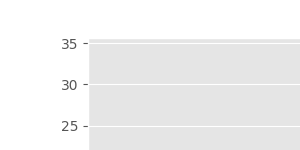

In [24]:
# VISUALIZE
vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list)

## p, q, v

<IPython.core.display.Javascript object>


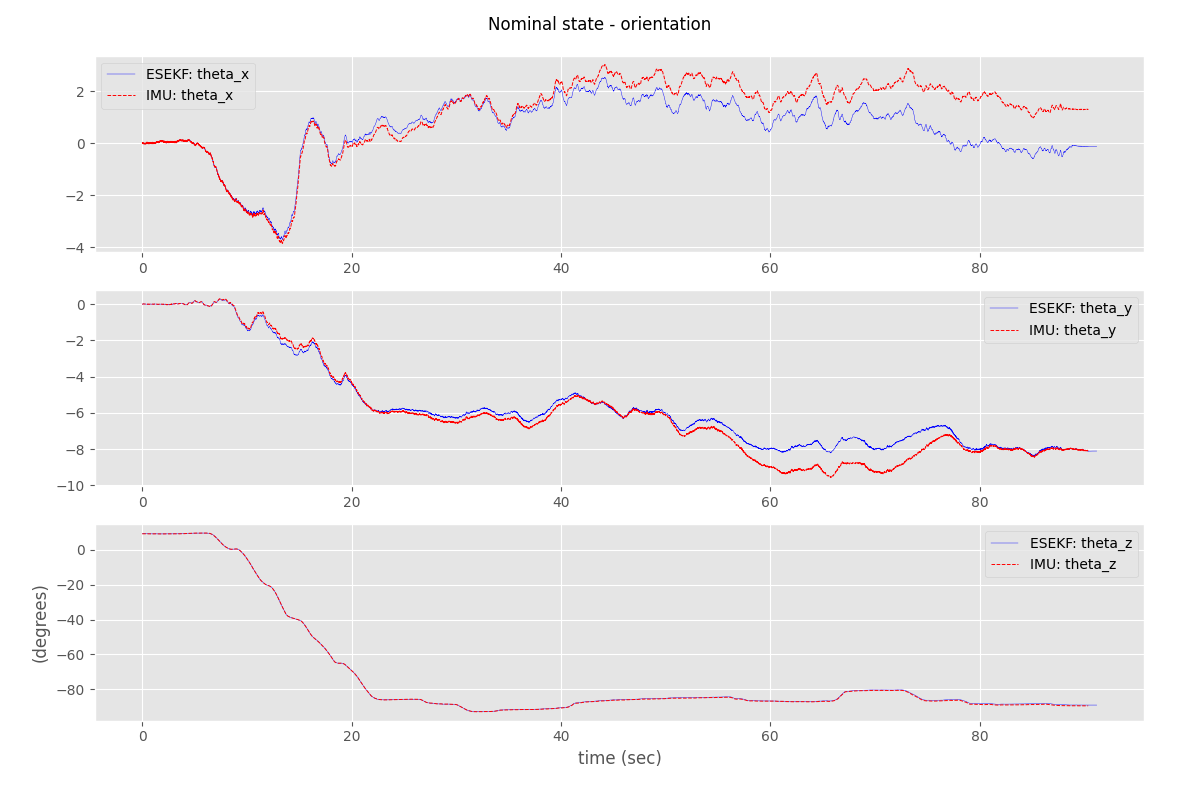

In [25]:
vis_ori(t_list, x_list, t_imu, e_imu)

<IPython.core.display.Javascript object>


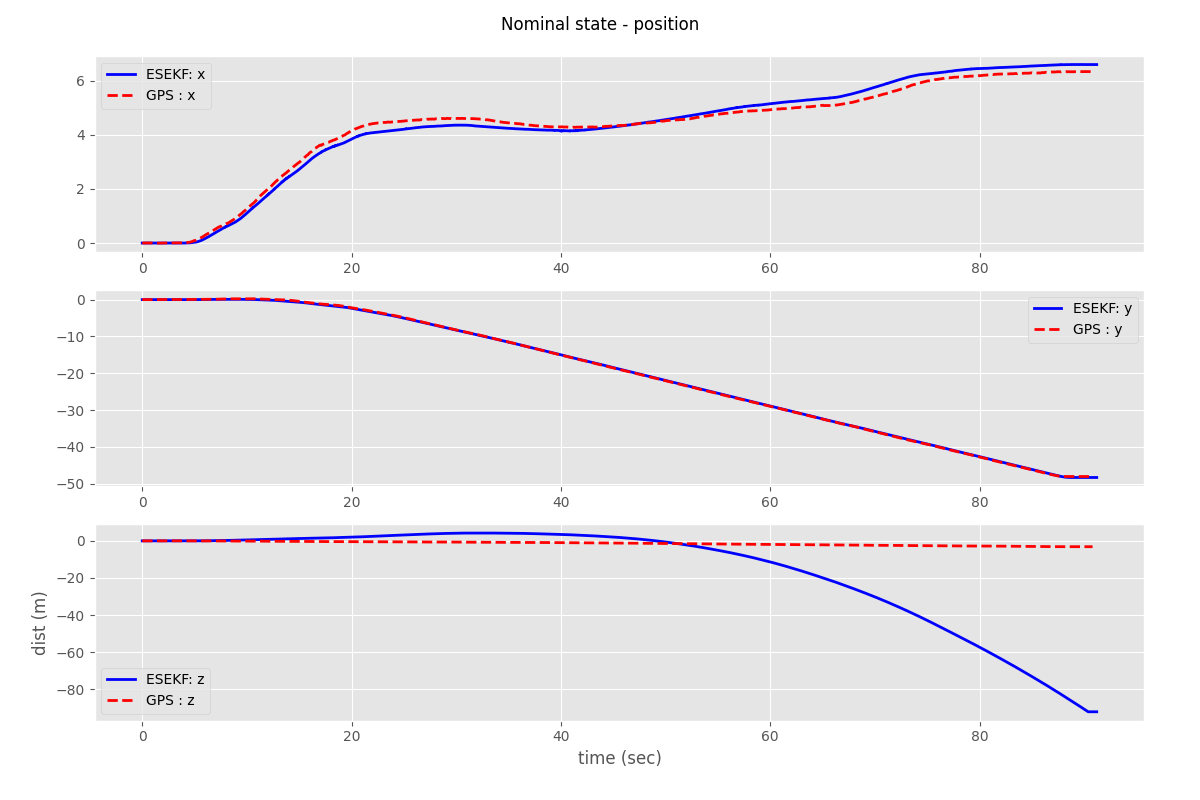

In [26]:
vis_p(t_list, x_list, t_gps, p_gps)

<IPython.core.display.Javascript object>


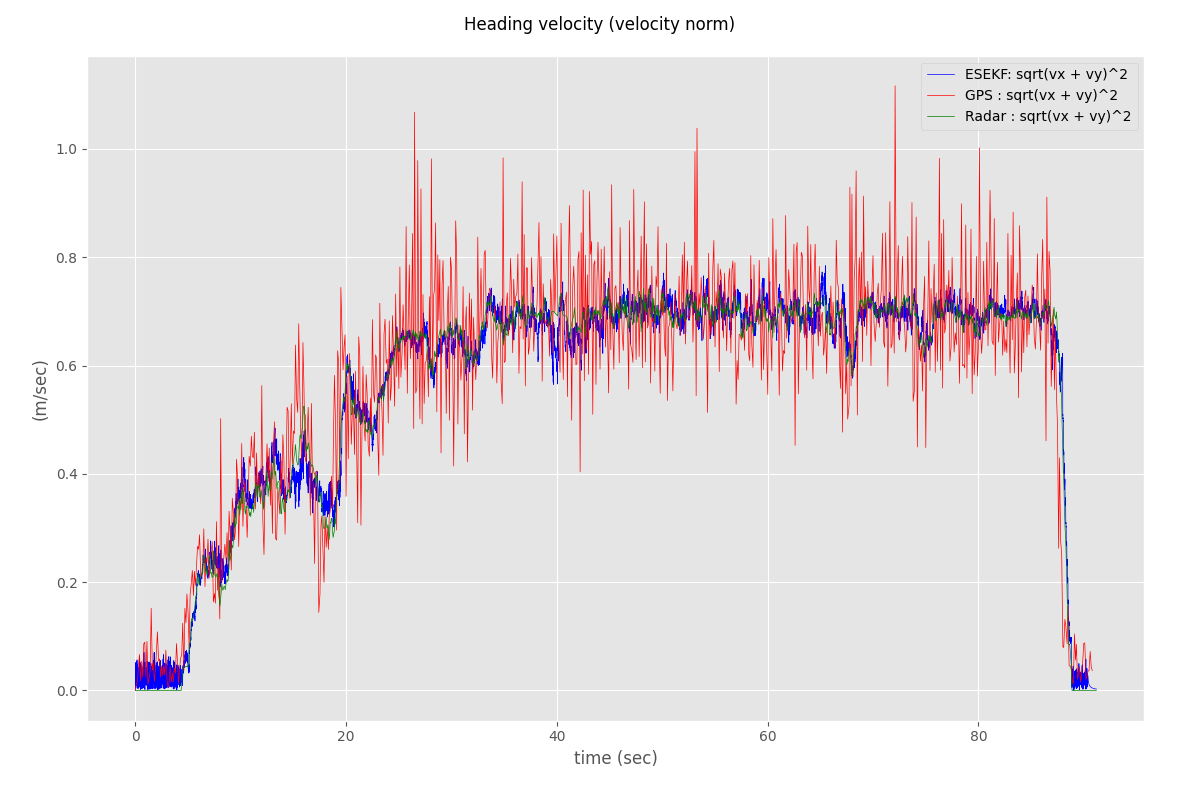

In [27]:
vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_cart_list, t_ro_list)

<IPython.core.display.Javascript object>


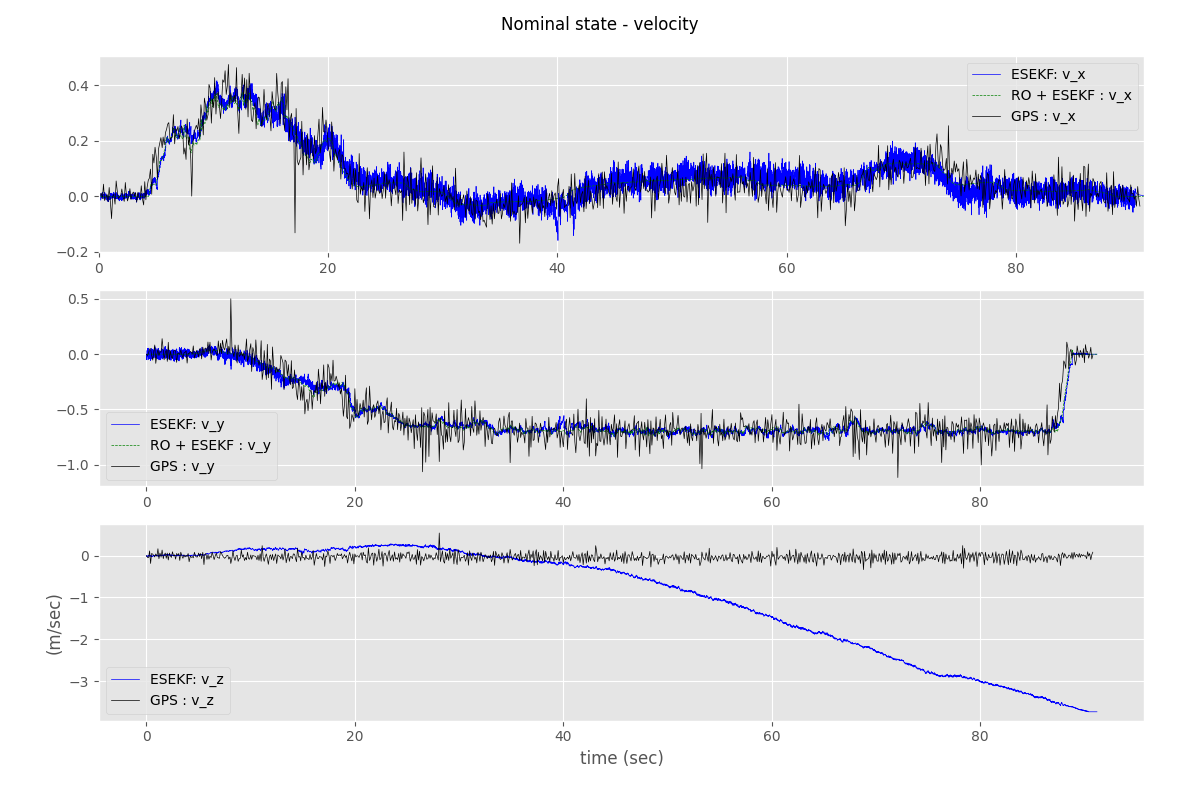

In [28]:
vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_cart_list, t_ro_list)

## rest

<IPython.core.display.Javascript object>


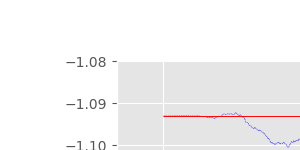

In [29]:
vis_wb(t_list, x_list, wb_imu)

## trajectories

In [64]:
p_list = x_list[:,0:3]

p_list_short = np.empty((0,3), float)
for i in range(len(t_gps)):
    dt, idx = get_IMU_reading(t_gps[i], t_list)
    p_list_short = np.append(p_list_short, p_list[idx].reshape(1,3), axis=0)

traj_RMSE(p_gps[:,0:2], p_list_short[:, 0:2])

0.18135721482741926

<IPython.core.display.Javascript object>


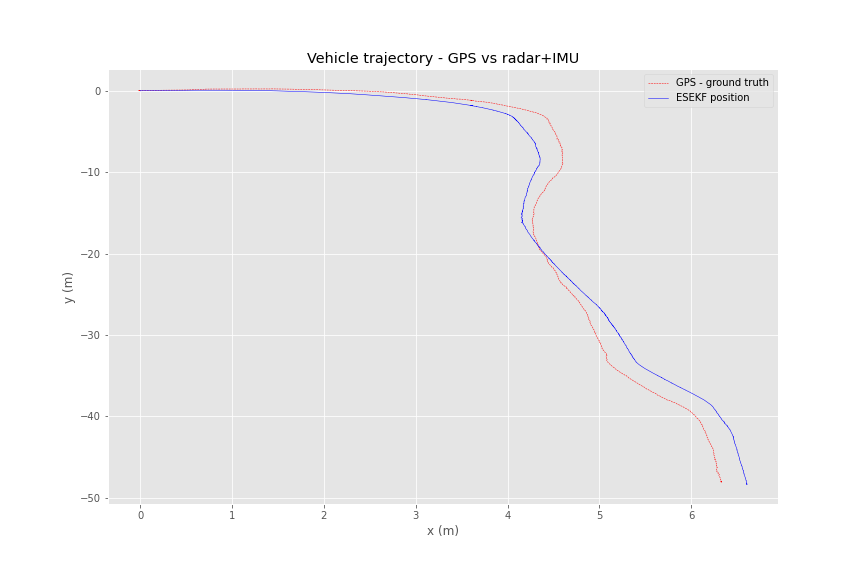

In [41]:
vis_traj_2d(x_list, p_gps)

<IPython.core.display.Javascript object>


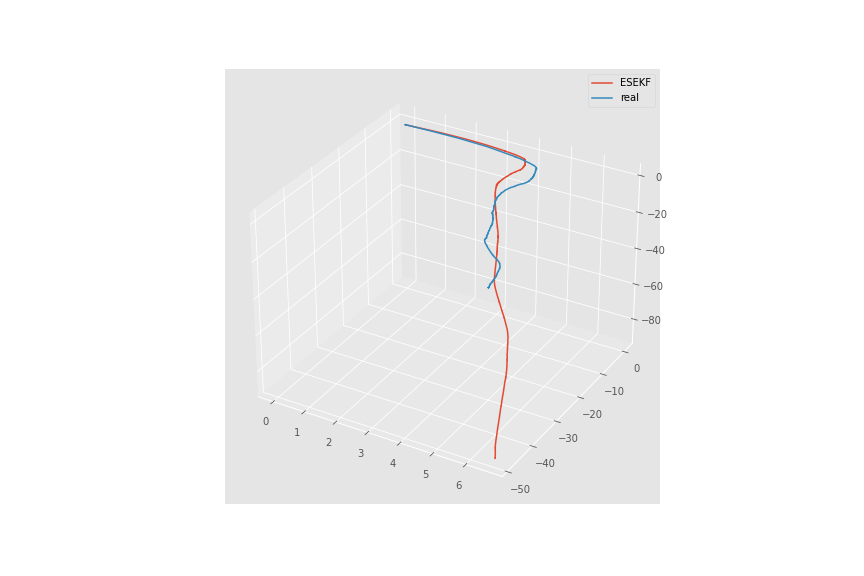

In [42]:
vis_traj_3d(x_list, p_gps)

# The End